# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Strong: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer. 
  - Boss: Implement [Self-Attention Pooling](https://arxiv.org/pdf/2008.01077v1.pdf) & [Additive Margin Softmax](https://arxiv.org/pdf/1801.05599.pdf) to further boost the performance.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/ac77388c90204a4c8daebeddd40ff916)
  - Slide: [link](https://docs.google.com/presentation/d/1HLAj7UUIjZOycDe7DaVLSwJfXVd3bXPOyzSb6Zk3hYU/edit?usp=sharing)
  - Data: [link](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

# Download dataset
- Data is [here](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

In [1]:
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partaa
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partab
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partac
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partad

# !cat Dataset.tar.gz.part* > Dataset.tar.gz

# unzip the file
# !tar zxvf Dataset.tar.gz

## Fix Random Seed

In [2]:
# import numpy as np
# import torch
# import random
import inspect

from utils import set_seed
lines = inspect.getsource(set_seed)
print(lines)

set_seed(87)

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

## Dataset
- Original dataset is [Voxceleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).
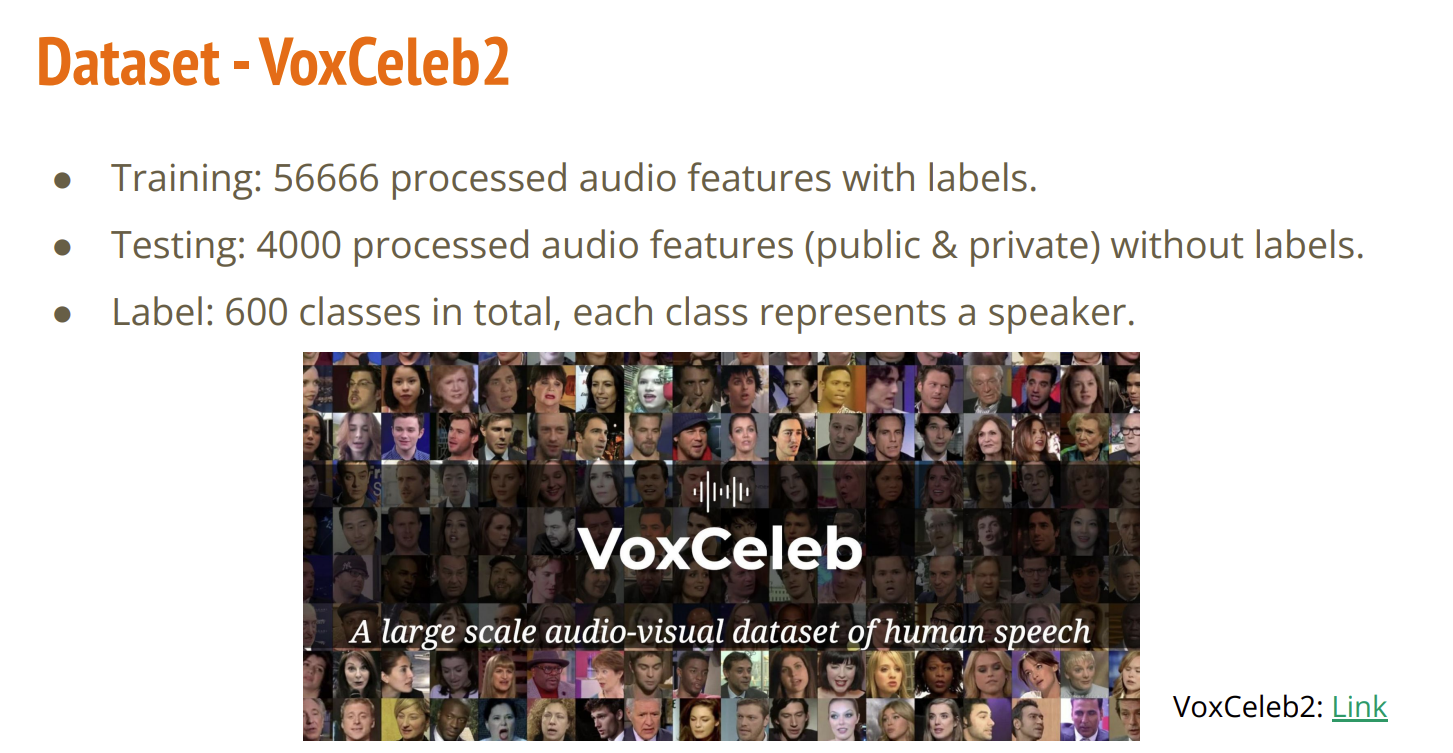


- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb2.
- We randomly select 600 speakers from Voxceleb2.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training. 
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary. 
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

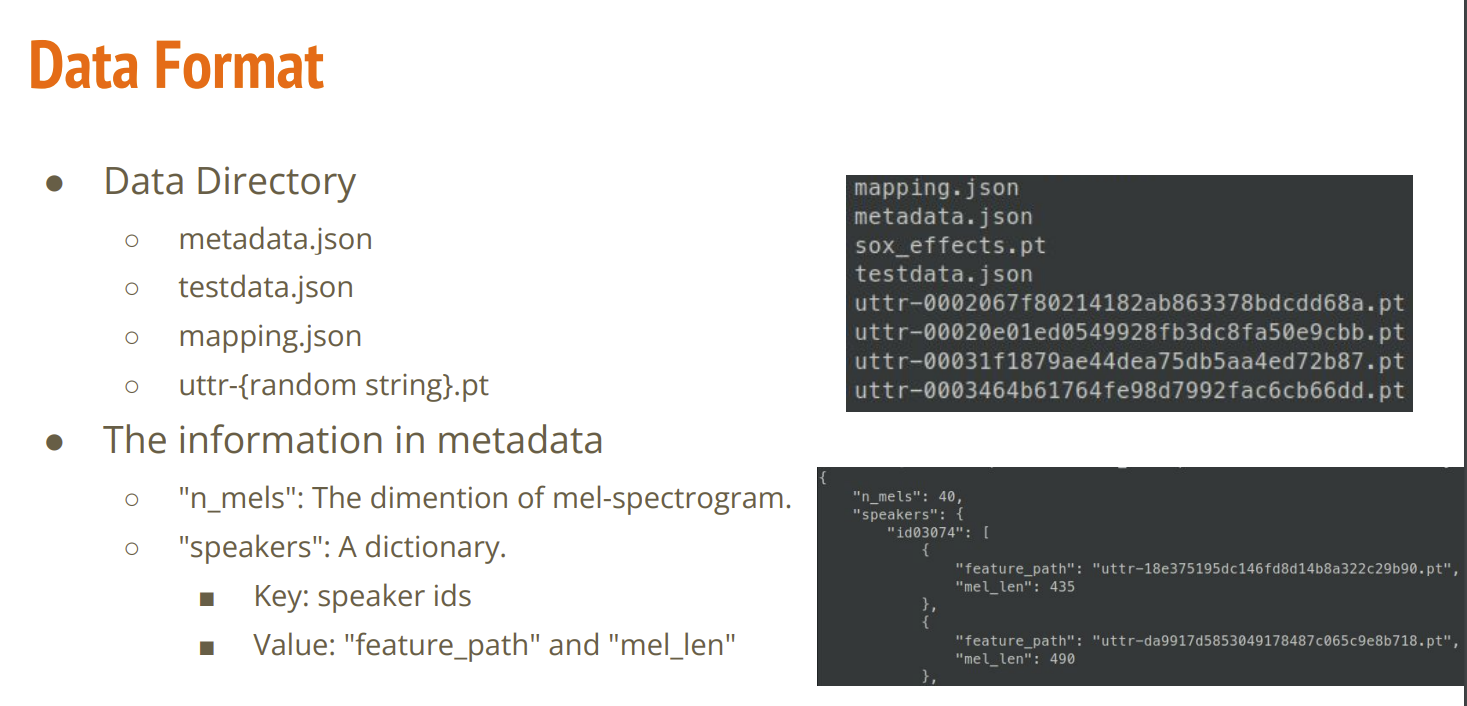

In [3]:
from data import myDataset
lines = inspect.getsource(myDataset)
print(lines)

class myDataset(Dataset):
    def __init__(self, data_dir, segment_len=128):
        self.data_dir = data_dir
        self.segment_len = segment_len
    
        # Load the mapping from speaker neme to their corresponding id. 
        mapping_path = Path(data_dir) / "mapping.json"
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping["speaker2id"]
    
        # Load metadata of training data.
        metadata_path = Path(data_dir) / "metadata.json"
        metadata = json.load(open(metadata_path))["speakers"]
    
        # Get the total number of speaker.
        self.speaker_num = len(metadata.keys())
        self.data = []
        for speaker in metadata.keys():
            for utterances in metadata[speaker]:
                self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
    def __len__(self):
            return len(self.data)
 
    def __getitem__(self, index):
        feat_path, speaker = self.data[index]
        # Load pr

### 在__getitem__裡面做這件事
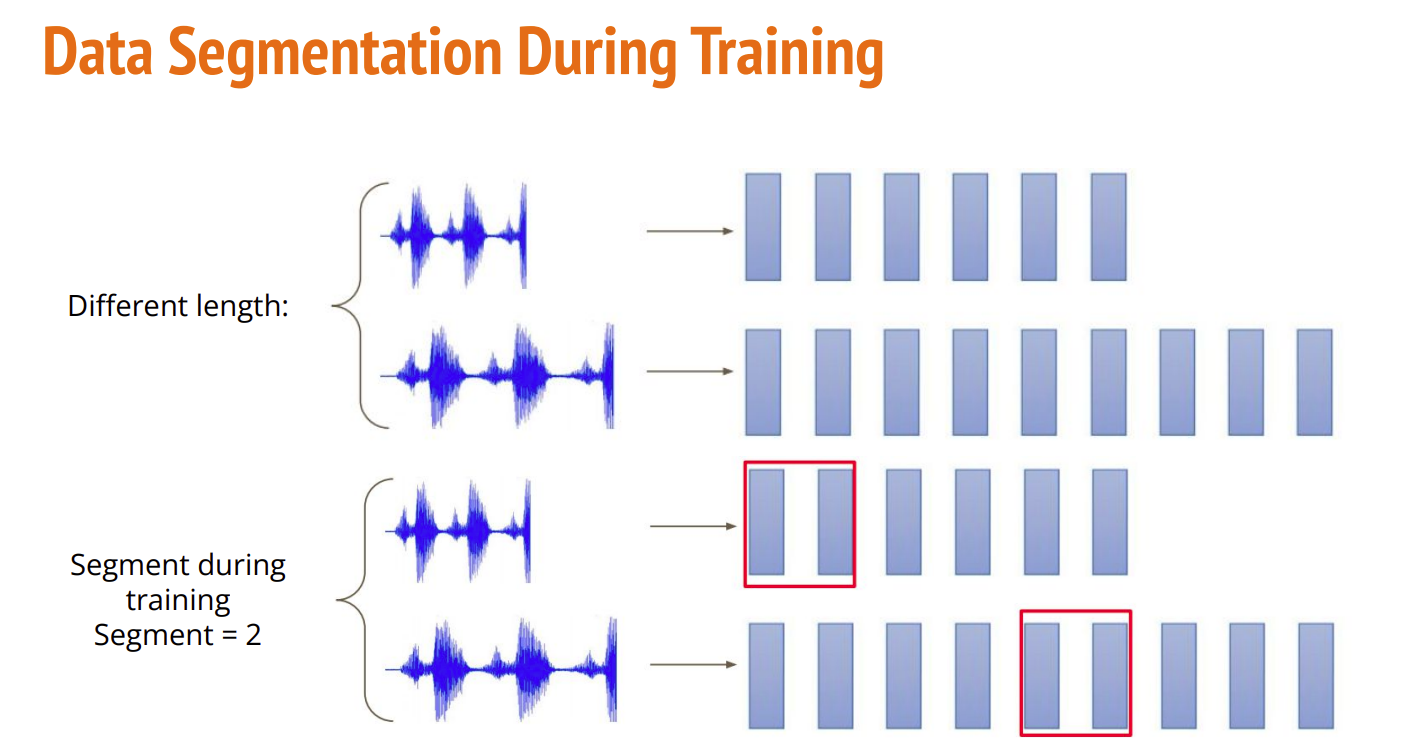

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from data import collate_batch, get_dataloader
lines = inspect.getsource(collate_batch)
print(lines)

lines = inspect.getsource(get_dataloader)
print(lines)

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    mel, speaker = zip(*batch)
    # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
    # mel: (batch size, length, 40)
    return mel, torch.FloatTensor(speaker).long()

def get_dataloader(data_dir, batch_size, n_workers):
    """Generate dataloader"""
    dataset = myDataset(data_dir)
    speaker_num = dataset.get_speaker_number()
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)

    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        p

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [5]:
from model import Boss_Classifier as Classifier
lines = inspect.getsource(Classifier)
print(lines)

class Boss_Classifier(nn.Module):
    def __init__(self, d_model=80, n_spks=600, dropout=0.1):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100

        self.encoder = Conformer(
            input_dim=d_model,
            num_heads=4,
            ffn_dim=256,
            num_layers=4,
            depthwise_conv_kernel_size=31,
        )    

        self.self_attn_pool = SelfAttentionPooling(d_model)  

        # Project the the dimension of features from d_model into speaker nums.
        self.pred_layer = nn.Sequential(
            # nn.Linear(d_model, d_model),
            nn.PReLU(),
            nn.Linear(d_model, n_spks),
        )

    def forward(self, mels):
        """
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_sp

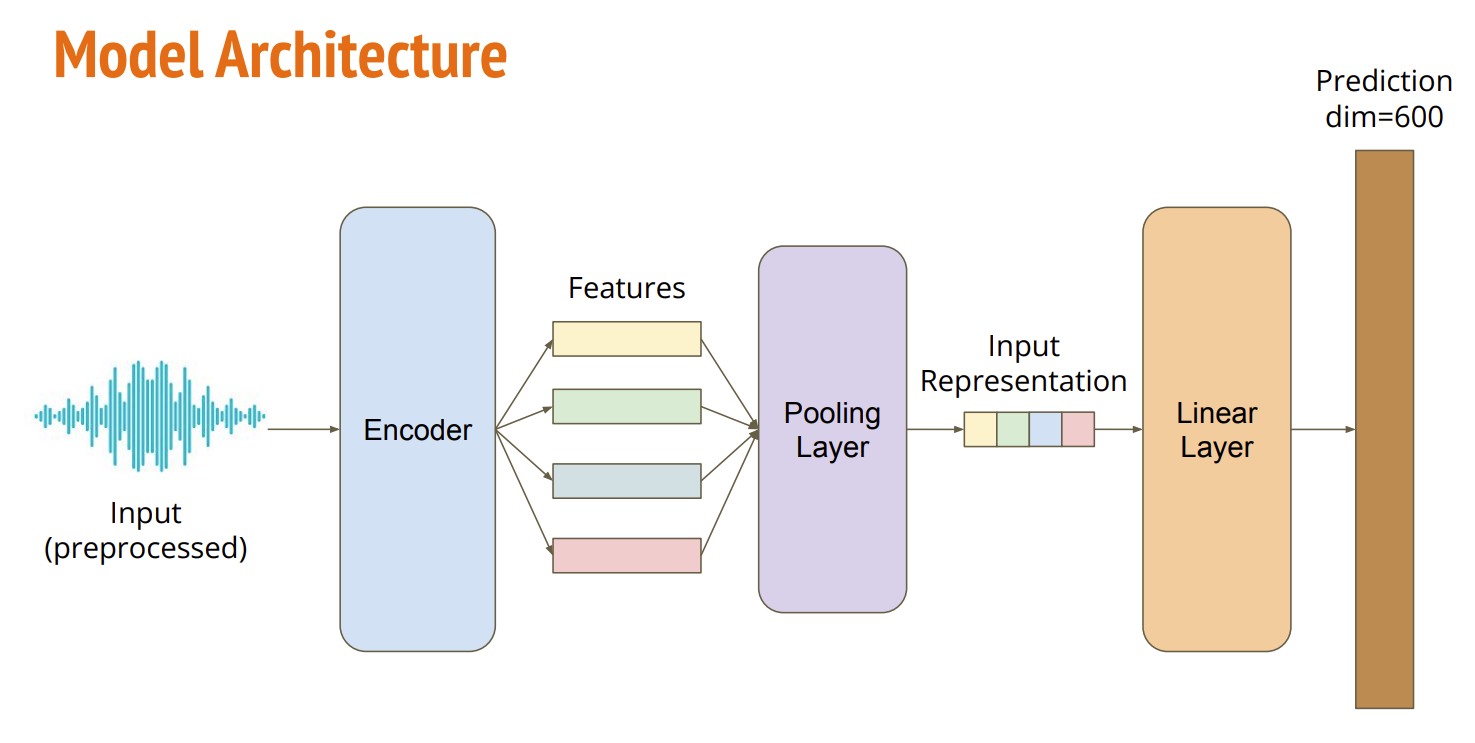

### Medium
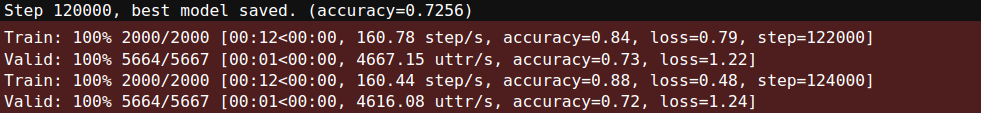

## Strong_Classifier
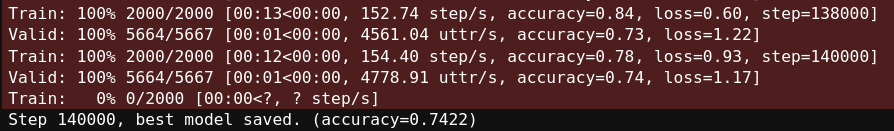

## Boss
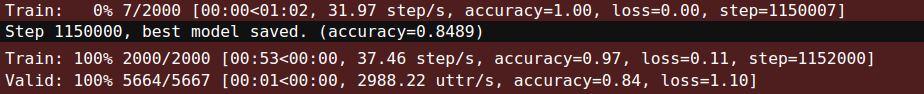

In [6]:
from process import AdMSoftmaxLoss
lines = inspect.getsource(AdMSoftmaxLoss)
print(lines)

class AdMSoftmaxLoss(nn.Module):

    def __init__(self, embedding_dim, no_classes, scale = 30.0, margin=0.4):
        '''
        Additive Margin Softmax Loss
        Attributes
        ----------
        embedding_dim : int 
            Dimension of the embedding vector
        no_classes : int
            Number of classes to be embedded
        scale : float
            Global scale factor
        margin : float
            Size of additive margin        
        '''
        super(AdMSoftmaxLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.embedding_dim = embedding_dim
        self.no_classes = no_classes
        self.embedding = nn.Embedding(no_classes, embedding_dim, max_norm=1)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, labels):
        '''
        Input shape (N, embedding_dim)
        '''
        n, m = x.shape     
        # print(n, m)   
        # print(self.embedding_dim)
        assert n == len(labels)
   

## accuracy too small...
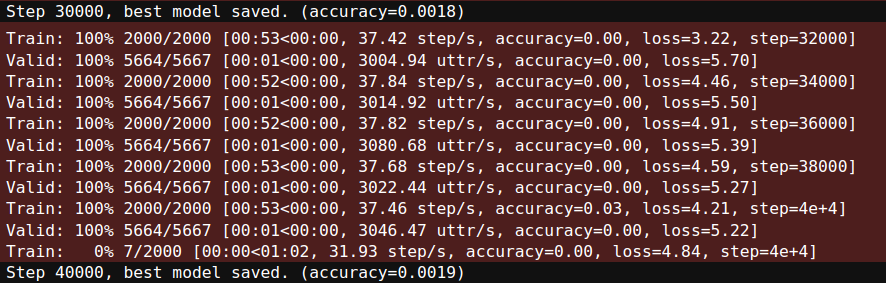

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [7]:
from utils import get_cosine_schedule_with_warmup
lines = inspect.getsource(get_cosine_schedule_with_warmup)
print(lines)

def get_cosine_schedule_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
        The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
        The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
        The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
        The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
        following a half-cosine).
        last_epoch (:obj:`int`, `option

# Model Function
- Model forward function.

In [8]:
from process import model_fn, valid, train
lines = inspect.getsource(model_fn)
print(lines)

def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""

    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)
   
    outs = model(mels)

    loss = criterion(outs, labels)

    # Get the speaker id with highest probability.
    preds = outs.argmax(1)
    # Compute accuracy.
    accuracy = torch.mean((preds == labels).float())

    return loss, accuracy



# Validate
- Calculate accuracy of the validation set.

In [9]:
lines = inspect.getsource(valid)
print(lines)

def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""

    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss, accuracy = model_fn(batch, model, criterion, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()

        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
            loss=f"{running_loss / (i+1):.2f}",
            accuracy=f"{running_accuracy / (i+1):.2f}",
        )

    pbar.close()
    model.train()

    return running_accuracy / len(dataloader)



# Train
- Training process of the self-attention model

In [10]:
lines = inspect.getsource(train)
print(lines)

def train(
    data_dir,
    save_path,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    total_steps,
    save_steps,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    model = Classifier(n_spks=speaker_num).to(device)
    criterion = nn.CrossEntropyLoss()
    # criterion = AdMSoftmaxLoss(embedding_dim=600, no_classes=600, scale = 30.0, margin=0.2).to(device) # Boss
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_accuracy = -1.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

 

# Main function

In [ ]:
def parse_args():
	"""arguments"""
	config = {
		"data_dir": "./Dataset",
		"save_path": "model.ckpt",
		"batch_size": 32,
		"n_workers": 8,
		"valid_steps": 2000,
		"warmup_steps": 1000,
		"save_steps": 10000,
		"total_steps": 1300000,
	}

	return config

if __name__ == "__main__":
	train(**parse_args())

[Info]: Use cuda now!


/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Info]: Finish loading data!
[Info]: Finish creating model!


Train:   0% 0/2000 [00:00<?, ? step/s]/home/leyan/Documents/Hung-yi-Lee/hw5_self_attention/model.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  att_w = softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
Train: 100% 2000/2000 [00:56<00:00, 35.69 step/s, accuracy=0.28, loss=3.66, step=2000]
Valid: 100% 5664/5667 [00:01<00:00, 3036.24 uttr/s, accuracy=0.17, loss=4.13]
Train: 100% 2000/2000 [00:50<00:00, 39.38 step/s, accuracy=0.28, loss=3.08, step=4000]
Valid: 100% 5664/5667 [00:01<00:00, 3139.58 uttr/s, accuracy=0.31, loss=3.19]
Train: 100% 2000/2000 [00:52<00:00, 37.87 step/s, accuracy=0.38, loss=2.54, step=6000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.88 uttr/s, accuracy=0.39, loss=2.74]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.47, loss=2.19, step=8000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.27 uttr/s, accuracy=0.45, loss=2.43]
Train: 100% 2000/2000 [00:51<00:00, 38.72 step/s, a

Step 10000, best model saved. (accuracy=0.5056)


Train: 100% 2000/2000 [00:51<00:00, 38.77 step/s, accuracy=0.72, loss=1.52, step=12000]
Valid: 100% 5664/5667 [00:01<00:00, 3161.61 uttr/s, accuracy=0.56, loss=1.90]
Train: 100% 2000/2000 [00:51<00:00, 38.78 step/s, accuracy=0.53, loss=2.40, step=14000]
Valid: 100% 5664/5667 [00:01<00:00, 3070.82 uttr/s, accuracy=0.59, loss=1.78]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.66, loss=1.30, step=16000]
Valid: 100% 5664/5667 [00:01<00:00, 3136.74 uttr/s, accuracy=0.62, loss=1.66]
Train: 100% 2000/2000 [00:51<00:00, 38.66 step/s, accuracy=0.72, loss=1.37, step=18000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.84 uttr/s, accuracy=0.62, loss=1.58]
Train: 100% 2000/2000 [00:51<00:00, 38.69 step/s, accuracy=0.69, loss=1.34, step=2e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3080.72 uttr/s, accuracy=0.64, loss=1.54]
Train:   0% 7/2000 [00:00<01:01, 32.55 step/s, accuracy=0.75, loss=1.07, step=2e+4]

Step 20000, best model saved. (accuracy=0.6375)


Train: 100% 2000/2000 [00:51<00:00, 38.68 step/s, accuracy=0.69, loss=1.22, step=22000]
Valid: 100% 5664/5667 [00:01<00:00, 3101.10 uttr/s, accuracy=0.65, loss=1.49]
Train: 100% 2000/2000 [00:52<00:00, 38.30 step/s, accuracy=0.84, loss=0.70, step=24000]
Valid: 100% 5664/5667 [00:01<00:00, 3154.25 uttr/s, accuracy=0.66, loss=1.47]
Train: 100% 2000/2000 [00:51<00:00, 38.62 step/s, accuracy=0.84, loss=0.77, step=26000]
Valid: 100% 5664/5667 [00:01<00:00, 3132.43 uttr/s, accuracy=0.66, loss=1.44]
Train: 100% 2000/2000 [00:51<00:00, 38.68 step/s, accuracy=0.72, loss=1.08, step=28000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.84 uttr/s, accuracy=0.67, loss=1.40]
Train: 100% 2000/2000 [00:51<00:00, 38.67 step/s, accuracy=0.62, loss=0.92, step=3e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3072.68 uttr/s, accuracy=0.69, loss=1.32]
Train:   0% 7/2000 [00:00<01:02, 31.74 step/s, accuracy=0.66, loss=1.06, step=3e+4]

Step 30000, best model saved. (accuracy=0.6900)


Train: 100% 2000/2000 [00:51<00:00, 38.83 step/s, accuracy=0.84, loss=0.67, step=32000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.49 uttr/s, accuracy=0.69, loss=1.34]
Train: 100% 2000/2000 [00:51<00:00, 39.08 step/s, accuracy=0.75, loss=0.89, step=34000]
Valid: 100% 5664/5667 [00:01<00:00, 3158.38 uttr/s, accuracy=0.70, loss=1.29]
Train: 100% 2000/2000 [00:51<00:00, 39.14 step/s, accuracy=0.75, loss=1.12, step=36000]
Valid: 100% 5664/5667 [00:01<00:00, 3138.03 uttr/s, accuracy=0.70, loss=1.31]
Train: 100% 2000/2000 [00:53<00:00, 37.54 step/s, accuracy=0.72, loss=0.62, step=38000]
Valid: 100% 5664/5667 [00:01<00:00, 2982.61 uttr/s, accuracy=0.71, loss=1.27]
Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=0.75, loss=0.80, step=4e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3144.98 uttr/s, accuracy=0.71, loss=1.25]
Train:   0% 7/2000 [00:00<00:57, 34.73 step/s, accuracy=0.81, loss=0.77, step=4e+4]

Step 40000, best model saved. (accuracy=0.7108)


Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.84, loss=0.93, step=42000]
Valid: 100% 5664/5667 [00:01<00:00, 3037.73 uttr/s, accuracy=0.71, loss=1.28]
Train: 100% 2000/2000 [00:51<00:00, 38.58 step/s, accuracy=0.91, loss=0.51, step=44000]
Valid: 100% 5664/5667 [00:01<00:00, 3062.97 uttr/s, accuracy=0.71, loss=1.22]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.88, loss=0.44, step=46000]
Valid: 100% 5664/5667 [00:01<00:00, 3047.86 uttr/s, accuracy=0.71, loss=1.28]
Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.84, loss=0.49, step=48000]
Valid: 100% 5664/5667 [00:01<00:00, 3126.69 uttr/s, accuracy=0.73, loss=1.18]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.69, loss=0.83, step=5e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3130.39 uttr/s, accuracy=0.72, loss=1.23]
Train:   0% 7/2000 [00:00<01:02, 31.79 step/s, accuracy=0.75, loss=0.74, step=5e+4]

Step 50000, best model saved. (accuracy=0.7293)


Train: 100% 2000/2000 [00:51<00:00, 38.57 step/s, accuracy=0.78, loss=0.76, step=52000]
Valid: 100% 5664/5667 [00:01<00:00, 3048.33 uttr/s, accuracy=0.71, loss=1.22]
Train: 100% 2000/2000 [00:51<00:00, 38.63 step/s, accuracy=0.78, loss=0.93, step=54000]
Valid: 100% 5664/5667 [00:01<00:00, 3074.78 uttr/s, accuracy=0.73, loss=1.15]
Train: 100% 2000/2000 [00:52<00:00, 38.21 step/s, accuracy=0.84, loss=0.55, step=56000]
Valid: 100% 5664/5667 [00:01<00:00, 3035.84 uttr/s, accuracy=0.72, loss=1.22]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.84, loss=0.55, step=58000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.85 uttr/s, accuracy=0.74, loss=1.17]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=0.78, loss=1.10, step=6e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3059.44 uttr/s, accuracy=0.73, loss=1.16]
Train:   0% 7/2000 [00:00<01:02, 31.92 step/s, accuracy=0.84, loss=0.43, step=6e+4]

Step 60000, best model saved. (accuracy=0.7375)


Train: 100% 2000/2000 [00:51<00:00, 38.96 step/s, accuracy=0.84, loss=0.72, step=62000]
Valid: 100% 5664/5667 [00:01<00:00, 3130.08 uttr/s, accuracy=0.74, loss=1.12]
Train: 100% 2000/2000 [00:51<00:00, 38.66 step/s, accuracy=0.88, loss=0.37, step=64000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.72 uttr/s, accuracy=0.73, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.94 step/s, accuracy=0.81, loss=0.93, step=66000]
Valid: 100% 5664/5667 [00:01<00:00, 3148.76 uttr/s, accuracy=0.74, loss=1.15]
Train: 100% 2000/2000 [00:51<00:00, 39.01 step/s, accuracy=0.88, loss=0.67, step=68000]
Valid: 100% 5664/5667 [00:01<00:00, 3160.93 uttr/s, accuracy=0.73, loss=1.17]
Train: 100% 2000/2000 [00:51<00:00, 39.05 step/s, accuracy=0.94, loss=0.32, step=7e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3111.72 uttr/s, accuracy=0.73, loss=1.15]
Train:   0% 7/2000 [00:00<01:01, 32.63 step/s, accuracy=0.91, loss=0.29, step=7e+4]

Step 70000, best model saved. (accuracy=0.7383)


Train: 100% 2000/2000 [00:51<00:00, 38.66 step/s, accuracy=0.88, loss=0.52, step=72000]
Valid: 100% 5664/5667 [00:01<00:00, 3146.17 uttr/s, accuracy=0.74, loss=1.17]
Train: 100% 2000/2000 [00:51<00:00, 38.97 step/s, accuracy=0.94, loss=0.27, step=74000]
Valid: 100% 5664/5667 [00:01<00:00, 3131.22 uttr/s, accuracy=0.73, loss=1.16]
Train: 100% 2000/2000 [00:51<00:00, 39.01 step/s, accuracy=0.97, loss=0.32, step=76000]
Valid: 100% 5664/5667 [00:01<00:00, 3144.42 uttr/s, accuracy=0.74, loss=1.16]
Train: 100% 2000/2000 [00:51<00:00, 39.08 step/s, accuracy=0.84, loss=0.55, step=78000]
Valid: 100% 5664/5667 [00:01<00:00, 3127.82 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.58 step/s, accuracy=0.88, loss=0.47, step=8e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3114.02 uttr/s, accuracy=0.74, loss=1.16]
Train:   0% 7/2000 [00:00<01:00, 32.91 step/s, accuracy=0.91, loss=0.37, step=8e+4]

Step 80000, best model saved. (accuracy=0.7465)


Train: 100% 2000/2000 [00:51<00:00, 39.02 step/s, accuracy=0.84, loss=0.38, step=82000]
Valid: 100% 5664/5667 [00:01<00:00, 3113.56 uttr/s, accuracy=0.74, loss=1.16]
Train: 100% 2000/2000 [00:51<00:00, 38.96 step/s, accuracy=0.91, loss=0.34, step=84000]
Valid: 100% 5664/5667 [00:01<00:00, 3177.84 uttr/s, accuracy=0.74, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.84 step/s, accuracy=0.78, loss=0.49, step=86000]
Valid: 100% 5664/5667 [00:01<00:00, 3095.58 uttr/s, accuracy=0.74, loss=1.17]
Train: 100% 2000/2000 [00:51<00:00, 38.57 step/s, accuracy=0.81, loss=0.62, step=88000]
Valid: 100% 5664/5667 [00:01<00:00, 3169.28 uttr/s, accuracy=0.75, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.83 step/s, accuracy=0.66, loss=1.33, step=9e+4] 
Valid: 100% 5664/5667 [00:01<00:00, 3125.43 uttr/s, accuracy=0.74, loss=1.14]
Train:   0% 7/2000 [00:00<01:02, 31.80 step/s, accuracy=0.88, loss=0.69, step=9e+4]

Step 90000, best model saved. (accuracy=0.7481)


Train: 100% 2000/2000 [00:51<00:00, 38.84 step/s, accuracy=0.72, loss=0.85, step=92000]
Valid: 100% 5664/5667 [00:01<00:00, 3123.98 uttr/s, accuracy=0.74, loss=1.15]
Train: 100% 2000/2000 [00:51<00:00, 38.60 step/s, accuracy=0.84, loss=0.37, step=94000]
Valid: 100% 5664/5667 [00:01<00:00, 3118.52 uttr/s, accuracy=0.75, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.79 step/s, accuracy=0.94, loss=0.27, step=96000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.40 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.77 step/s, accuracy=0.78, loss=0.80, step=98000]
Valid: 100% 5664/5667 [00:01<00:00, 3136.24 uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.92 step/s, accuracy=0.78, loss=0.65, step=1e+5] 
Valid: 100% 5664/5667 [00:01<00:00, 3162.54 uttr/s, accuracy=0.74, loss=1.14]
Train:   0% 7/2000 [00:00<01:00, 32.73 step/s, accuracy=0.91, loss=0.28, step=1e+5]

Step 100000, best model saved. (accuracy=0.7542)


Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.94, loss=0.31, step=102000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.88 uttr/s, accuracy=0.75, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.88 step/s, accuracy=0.91, loss=0.18, step=104000]
Valid: 100% 5664/5667 [00:01<00:00, 3122.17 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.86 step/s, accuracy=0.88, loss=0.29, step=106000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.31 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.87 step/s, accuracy=0.91, loss=0.35, step=108000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.39 uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.56 step/s, accuracy=0.88, loss=0.43, step=110000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.29 uttr/s, accuracy=0.75, loss=1.09]
Train:   0% 7/2000 [00:00<01:03, 31.42 step/s, accuracy=0.91, loss=0.31, step=110007]

Step 110000, best model saved. (accuracy=0.7599)


Train: 100% 2000/2000 [00:51<00:00, 38.80 step/s, accuracy=0.94, loss=0.39, step=112000]
Valid: 100% 5664/5667 [00:01<00:00, 3148.37 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.89 step/s, accuracy=0.91, loss=0.38, step=114000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.59 uttr/s, accuracy=0.74, loss=1.15]
Train: 100% 2000/2000 [00:51<00:00, 38.79 step/s, accuracy=0.84, loss=0.52, step=116000]
Valid: 100% 5664/5667 [00:01<00:00, 3054.06 uttr/s, accuracy=0.75, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.25 step/s, accuracy=0.91, loss=0.42, step=118000]
Valid: 100% 5664/5667 [00:01<00:00, 3088.83 uttr/s, accuracy=0.75, loss=1.12]
Train: 100% 2000/2000 [00:51<00:00, 38.82 step/s, accuracy=0.81, loss=0.65, step=120000]
Valid: 100% 5664/5667 [00:01<00:00, 3154.67 uttr/s, accuracy=0.73, loss=1.17]
Train:   0% 7/2000 [00:00<00:57, 34.73 step/s, accuracy=0.75, loss=0.89, step=120007]

Step 120000, best model saved. (accuracy=0.7599)


Train: 100% 2000/2000 [00:51<00:00, 38.64 step/s, accuracy=0.94, loss=0.17, step=122000]
Valid: 100% 5664/5667 [00:01<00:00, 3065.95 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.87 step/s, accuracy=0.84, loss=0.51, step=124000]
Valid: 100% 5664/5667 [00:01<00:00, 3086.90 uttr/s, accuracy=0.76, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.81, loss=0.65, step=126000]
Valid: 100% 5664/5667 [00:01<00:00, 3148.65 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.75 step/s, accuracy=0.81, loss=0.59, step=128000]
Valid: 100% 5664/5667 [00:01<00:00, 3148.77 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.73 step/s, accuracy=0.75, loss=0.55, step=130000]
Valid: 100% 5664/5667 [00:01<00:00, 3153.63 uttr/s, accuracy=0.75, loss=1.14]
Train:   0% 7/2000 [00:00<00:56, 35.14 step/s, accuracy=0.88, loss=0.40, step=130007]

Step 130000, best model saved. (accuracy=0.7634)


Train: 100% 2000/2000 [00:51<00:00, 38.79 step/s, accuracy=0.81, loss=0.57, step=132000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.26 uttr/s, accuracy=0.75, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.91, loss=0.41, step=134000]
Valid: 100% 5664/5667 [00:01<00:00, 3120.11 uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.79 step/s, accuracy=0.94, loss=0.38, step=136000]
Valid: 100% 5664/5667 [00:01<00:00, 3198.94 uttr/s, accuracy=0.75, loss=1.12]
Train: 100% 2000/2000 [00:51<00:00, 38.77 step/s, accuracy=0.94, loss=0.24, step=138000]
Valid: 100% 5664/5667 [00:01<00:00, 3098.98 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.71 step/s, accuracy=0.75, loss=0.82, step=140000]
Valid: 100% 5664/5667 [00:01<00:00, 3088.72 uttr/s, accuracy=0.75, loss=1.10]
Train:   0% 7/2000 [00:00<01:01, 32.61 step/s, accuracy=0.88, loss=0.31, step=140007]

Step 140000, best model saved. (accuracy=0.7634)


Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=0.97, loss=0.20, step=142000]
Valid: 100% 5664/5667 [00:01<00:00, 3125.54 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.61 step/s, accuracy=0.97, loss=0.21, step=144000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.68 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.68 step/s, accuracy=0.91, loss=0.68, step=146000]
Valid: 100% 5664/5667 [00:01<00:00, 3124.28 uttr/s, accuracy=0.75, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.65 step/s, accuracy=1.00, loss=0.13, step=148000]
Valid: 100% 5664/5667 [00:01<00:00, 2980.74 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.84, loss=0.37, step=150000]
Valid: 100% 5664/5667 [00:01<00:00, 3145.43 uttr/s, accuracy=0.75, loss=1.11]
Train:   0% 7/2000 [00:00<01:00, 32.76 step/s, accuracy=0.81, loss=0.43, step=150007]

Step 150000, best model saved. (accuracy=0.7677)


Train: 100% 2000/2000 [00:51<00:00, 38.60 step/s, accuracy=0.91, loss=0.35, step=152000]
Valid: 100% 5664/5667 [00:01<00:00, 3152.19 uttr/s, accuracy=0.75, loss=1.14]
Train: 100% 2000/2000 [00:51<00:00, 38.67 step/s, accuracy=0.88, loss=0.27, step=154000]
Valid: 100% 5664/5667 [00:01<00:00, 3117.83 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.69 step/s, accuracy=0.94, loss=0.26, step=156000]
Valid: 100% 5664/5667 [00:01<00:00, 3046.07 uttr/s, accuracy=0.76, loss=1.13]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.97, loss=0.29, step=158000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.95 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.71 step/s, accuracy=0.88, loss=0.55, step=160000]
Valid: 100% 5664/5667 [00:01<00:00, 3133.74 uttr/s, accuracy=0.76, loss=1.06]
Train:   0% 7/2000 [00:00<01:00, 33.10 step/s, accuracy=0.88, loss=0.42, step=160007]

Step 160000, best model saved. (accuracy=0.7677)


Train: 100% 2000/2000 [00:51<00:00, 38.61 step/s, accuracy=0.91, loss=0.56, step=162000]
Valid: 100% 5664/5667 [00:01<00:00, 3121.26 uttr/s, accuracy=0.74, loss=1.13]
Train: 100% 2000/2000 [00:51<00:00, 38.57 step/s, accuracy=0.81, loss=0.62, step=164000]
Valid: 100% 5664/5667 [00:01<00:00, 3149.05 uttr/s, accuracy=0.75, loss=1.13]
Train: 100% 2000/2000 [00:52<00:00, 38.26 step/s, accuracy=0.84, loss=0.34, step=166000]
Valid: 100% 5664/5667 [00:01<00:00, 3130.40 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=0.94, loss=0.25, step=168000]
Valid: 100% 5664/5667 [00:01<00:00, 3112.17 uttr/s, accuracy=0.76, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.64 step/s, accuracy=0.81, loss=0.64, step=170000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.77 uttr/s, accuracy=0.75, loss=1.13]
Train:   0% 7/2000 [00:00<00:58, 33.79 step/s, accuracy=0.81, loss=0.70, step=170007]

Step 170000, best model saved. (accuracy=0.7677)


Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.81, loss=0.52, step=172000]
Valid: 100% 5664/5667 [00:01<00:00, 3101.43 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.97, loss=0.23, step=174000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.08 uttr/s, accuracy=0.77, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.56 step/s, accuracy=0.91, loss=0.41, step=176000]
Valid: 100% 5664/5667 [00:01<00:00, 3145.87 uttr/s, accuracy=0.76, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.59 step/s, accuracy=0.78, loss=0.67, step=178000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.33 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.91, loss=0.34, step=180000]
Valid: 100% 5664/5667 [00:01<00:00, 3107.46 uttr/s, accuracy=0.77, loss=1.06]
Train:   0% 8/2000 [00:00<00:57, 34.49 step/s, accuracy=0.88, loss=0.36, step=180008]

Step 180000, best model saved. (accuracy=0.7687)


Train: 100% 2000/2000 [00:52<00:00, 38.20 step/s, accuracy=0.78, loss=0.74, step=182000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.28 uttr/s, accuracy=0.75, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.55 step/s, accuracy=0.97, loss=0.21, step=184000]
Valid: 100% 5664/5667 [00:01<00:00, 3124.05 uttr/s, accuracy=0.75, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.53 step/s, accuracy=0.94, loss=0.19, step=186000]
Valid: 100% 5664/5667 [00:01<00:00, 2979.95 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.91, loss=0.22, step=188000]
Valid: 100% 5664/5667 [00:01<00:00, 3129.64 uttr/s, accuracy=0.76, loss=1.09]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.97, loss=0.15, step=190000]
Valid: 100% 5664/5667 [00:01<00:00, 3142.05 uttr/s, accuracy=0.77, loss=1.05]
Train:   0% 7/2000 [00:00<01:00, 32.95 step/s, accuracy=0.78, loss=0.80, step=190007]

Step 190000, best model saved. (accuracy=0.7687)


Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.88, loss=0.43, step=192000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.91 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.88, loss=0.41, step=194000]
Valid: 100% 5664/5667 [00:01<00:00, 3121.10 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.21 step/s, accuracy=0.94, loss=0.21, step=196000]
Valid: 100% 5664/5667 [00:01<00:00, 3137.86 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.94, loss=0.24, step=198000]
Valid: 100% 5664/5667 [00:01<00:00, 2886.47 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.81, loss=0.59, step=2e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 3146.50 uttr/s, accuracy=0.76, loss=1.13]
Train:   0% 7/2000 [00:00<01:02, 31.93 step/s, accuracy=0.94, loss=0.19, step=2e+5]

Step 200000, best model saved. (accuracy=0.7744)


Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.91, loss=0.38, step=202000]
Valid: 100% 5664/5667 [00:01<00:00, 3163.46 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.91, loss=0.28, step=204000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.18 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.88, loss=0.34, step=206000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.02 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.97, loss=0.22, step=208000]
Valid: 100% 5664/5667 [00:01<00:00, 3175.96 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.94, loss=0.23, step=210000]
Valid: 100% 5664/5667 [00:01<00:00, 3083.48 uttr/s, accuracy=0.76, loss=1.10]
Train:   0% 7/2000 [00:00<01:00, 32.71 step/s, accuracy=0.88, loss=0.56, step=210007]

Step 210000, best model saved. (accuracy=0.7744)


Train: 100% 2000/2000 [00:52<00:00, 38.18 step/s, accuracy=0.88, loss=0.43, step=212000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.61 uttr/s, accuracy=0.76, loss=1.13]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.88, loss=0.44, step=214000]
Valid: 100% 5664/5667 [00:01<00:00, 3153.60 uttr/s, accuracy=0.76, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.84, loss=0.48, step=216000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.31 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.84, loss=0.52, step=218000]
Valid: 100% 5664/5667 [00:01<00:00, 3025.77 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.97, loss=0.10, step=220000]
Valid: 100% 5664/5667 [00:01<00:00, 3130.59 uttr/s, accuracy=0.77, loss=1.09]
Train:   0% 7/2000 [00:00<01:01, 32.33 step/s, accuracy=1.00, loss=0.15, step=220007]

Step 220000, best model saved. (accuracy=0.7744)


Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.91, loss=0.44, step=222000]
Valid: 100% 5664/5667 [00:01<00:00, 3128.10 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.91, loss=0.27, step=224000]
Valid: 100% 5664/5667 [00:01<00:00, 3086.46 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:54<00:00, 36.49 step/s, accuracy=0.94, loss=0.12, step=226000]
Valid: 100% 5664/5667 [00:02<00:00, 2739.87 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:54<00:00, 36.86 step/s, accuracy=0.94, loss=0.22, step=228000]
Valid: 100% 5664/5667 [00:02<00:00, 2779.82 uttr/s, accuracy=0.76, loss=1.09]
Train: 100% 2000/2000 [00:53<00:00, 37.36 step/s, accuracy=0.94, loss=0.50, step=230000]
Valid: 100% 5664/5667 [00:01<00:00, 3007.92 uttr/s, accuracy=0.77, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.25 step/s, accuracy=0.84, loss=0.43, step=230007]

Step 230000, best model saved. (accuracy=0.7744)


Train: 100% 2000/2000 [00:52<00:00, 37.89 step/s, accuracy=0.84, loss=0.54, step=232000]
Valid: 100% 5664/5667 [00:01<00:00, 3023.21 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.00 step/s, accuracy=0.94, loss=0.29, step=234000]
Valid: 100% 5664/5667 [00:01<00:00, 3004.73 uttr/s, accuracy=0.77, loss=1.11]
Train: 100% 2000/2000 [00:53<00:00, 37.55 step/s, accuracy=0.88, loss=0.37, step=236000]
Valid: 100% 5664/5667 [00:01<00:00, 3033.76 uttr/s, accuracy=0.76, loss=1.05]
Train: 100% 2000/2000 [00:53<00:00, 37.32 step/s, accuracy=0.94, loss=0.19, step=238000]
Valid: 100% 5664/5667 [00:02<00:00, 2658.62 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.42 step/s, accuracy=0.91, loss=0.27, step=240000]
Valid: 100% 5664/5667 [00:01<00:00, 2937.75 uttr/s, accuracy=0.76, loss=1.07]
Train:   0% 7/2000 [00:00<01:03, 31.45 step/s, accuracy=0.91, loss=0.32, step=240007]

Step 240000, best model saved. (accuracy=0.7744)


Train: 100% 2000/2000 [00:52<00:00, 37.78 step/s, accuracy=0.91, loss=0.31, step=242000]
Valid: 100% 5664/5667 [00:01<00:00, 2999.59 uttr/s, accuracy=0.78, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 37.74 step/s, accuracy=0.88, loss=0.41, step=244000]
Valid: 100% 5664/5667 [00:01<00:00, 3019.71 uttr/s, accuracy=0.76, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.04 step/s, accuracy=0.91, loss=0.26, step=246000]
Valid: 100% 5664/5667 [00:01<00:00, 2998.69 uttr/s, accuracy=0.77, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.84, loss=0.39, step=248000]
Valid: 100% 5664/5667 [00:02<00:00, 2755.69 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 37.87 step/s, accuracy=0.91, loss=0.44, step=250000]
Valid: 100% 5664/5667 [00:01<00:00, 2907.92 uttr/s, accuracy=0.76, loss=1.10]
Train:   0% 7/2000 [00:00<00:58, 34.02 step/s, accuracy=0.88, loss=0.38, step=250007]

Step 250000, best model saved. (accuracy=0.7758)


Train: 100% 2000/2000 [00:53<00:00, 37.55 step/s, accuracy=0.94, loss=0.27, step=252000]
Valid: 100% 5664/5667 [00:01<00:00, 3012.39 uttr/s, accuracy=0.77, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 37.91 step/s, accuracy=0.91, loss=0.36, step=254000]
Valid: 100% 5664/5667 [00:01<00:00, 2946.77 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 37.96 step/s, accuracy=0.81, loss=0.34, step=256000]
Valid: 100% 5664/5667 [00:01<00:00, 3044.25 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.91, loss=0.36, step=258000]
Valid: 100% 5664/5667 [00:01<00:00, 2992.74 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 37.74 step/s, accuracy=0.91, loss=0.22, step=260000]
Valid: 100% 5664/5667 [00:01<00:00, 3056.60 uttr/s, accuracy=0.77, loss=1.04]
Train:   0% 7/2000 [00:00<00:58, 34.04 step/s, accuracy=0.94, loss=0.27, step=260007]

Step 260000, best model saved. (accuracy=0.7758)


Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=1.00, loss=0.15, step=262000]
Valid: 100% 5664/5667 [00:01<00:00, 3057.62 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.20 step/s, accuracy=0.94, loss=0.20, step=264000]
Valid: 100% 5664/5667 [00:01<00:00, 3019.45 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.78, loss=0.60, step=266000]
Valid: 100% 5664/5667 [00:01<00:00, 3026.49 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 37.74 step/s, accuracy=0.91, loss=0.32, step=268000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.72 uttr/s, accuracy=0.77, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 38.15 step/s, accuracy=0.94, loss=0.26, step=270000]
Valid: 100% 5664/5667 [00:01<00:00, 3063.67 uttr/s, accuracy=0.77, loss=1.08]
Train:   0% 7/2000 [00:00<00:59, 33.39 step/s, accuracy=0.78, loss=0.62, step=270007]

Step 270000, best model saved. (accuracy=0.7758)


Train: 100% 2000/2000 [00:52<00:00, 38.24 step/s, accuracy=0.97, loss=0.26, step=272000]
Valid: 100% 5664/5667 [00:01<00:00, 3007.35 uttr/s, accuracy=0.76, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 37.91 step/s, accuracy=0.94, loss=0.19, step=274000]
Valid: 100% 5664/5667 [00:01<00:00, 3031.02 uttr/s, accuracy=0.76, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.26 step/s, accuracy=0.94, loss=0.50, step=276000]
Valid: 100% 5664/5667 [00:01<00:00, 3006.45 uttr/s, accuracy=0.77, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.23 step/s, accuracy=0.97, loss=0.19, step=278000]
Valid: 100% 5664/5667 [00:01<00:00, 2960.98 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.84, loss=0.63, step=280000]
Valid: 100% 5664/5667 [00:01<00:00, 2993.10 uttr/s, accuracy=0.77, loss=1.09]
Train:   0% 7/2000 [00:00<00:56, 35.21 step/s, accuracy=0.91, loss=0.43, step=280007]

Step 280000, best model saved. (accuracy=0.7758)


Train: 100% 2000/2000 [00:52<00:00, 37.85 step/s, accuracy=0.91, loss=0.23, step=282000]
Valid: 100% 5664/5667 [00:01<00:00, 3098.28 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.94, loss=0.24, step=284000]
Valid: 100% 5664/5667 [00:01<00:00, 3036.05 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.78, loss=0.49, step=286000]
Valid: 100% 5664/5667 [00:01<00:00, 2958.91 uttr/s, accuracy=0.76, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.88, loss=0.39, step=288000]
Valid: 100% 5664/5667 [00:01<00:00, 3035.96 uttr/s, accuracy=0.77, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 37.83 step/s, accuracy=0.97, loss=0.15, step=290000]
Valid: 100% 5664/5667 [00:01<00:00, 3041.96 uttr/s, accuracy=0.78, loss=1.00]
Train:   0% 7/2000 [00:00<00:57, 34.40 step/s, accuracy=0.81, loss=0.63, step=290007]

Step 290000, best model saved. (accuracy=0.7797)


Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.91, loss=0.22, step=292000]
Valid: 100% 5664/5667 [00:01<00:00, 3067.72 uttr/s, accuracy=0.78, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.81, loss=0.55, step=294000]
Valid: 100% 5664/5667 [00:01<00:00, 3047.99 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=0.84, loss=0.68, step=296000]
Valid: 100% 5664/5667 [00:01<00:00, 3082.62 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 37.87 step/s, accuracy=0.88, loss=0.42, step=298000]
Valid: 100% 5664/5667 [00:01<00:00, 3051.07 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.18 step/s, accuracy=0.88, loss=0.43, step=3e+5]  
Valid: 100% 5664/5667 [00:02<00:00, 2672.34 uttr/s, accuracy=0.77, loss=1.07]
Train:   0% 5/2000 [00:00<01:16, 26.21 step/s, accuracy=0.94, loss=0.19, step=3e+5]

Step 300000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.91, loss=0.39, step=302000]
Valid: 100% 5664/5667 [00:01<00:00, 3031.87 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.84, loss=0.60, step=304000]
Valid: 100% 5664/5667 [00:01<00:00, 3024.08 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=1.00, loss=0.05, step=306000]
Valid: 100% 5664/5667 [00:01<00:00, 3033.44 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.12 step/s, accuracy=0.88, loss=0.65, step=308000]
Valid: 100% 5664/5667 [00:01<00:00, 3039.28 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 37.77 step/s, accuracy=0.94, loss=0.41, step=310000]
Valid: 100% 5664/5667 [00:01<00:00, 2853.99 uttr/s, accuracy=0.76, loss=1.16]
Train:   0% 7/2000 [00:00<01:01, 32.59 step/s, accuracy=0.94, loss=0.35, step=310007]

Step 310000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.88, loss=0.31, step=312000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.48 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 37.96 step/s, accuracy=0.91, loss=0.46, step=314000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.88 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=0.94, loss=0.14, step=316000]
Valid: 100% 5664/5667 [00:01<00:00, 3107.83 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:54<00:00, 36.75 step/s, accuracy=0.94, loss=0.50, step=318000]
Valid: 100% 5664/5667 [00:01<00:00, 2953.05 uttr/s, accuracy=0.76, loss=1.11]
Train: 100% 2000/2000 [00:54<00:00, 36.74 step/s, accuracy=0.94, loss=0.35, step=320000]
Valid: 100% 5664/5667 [00:01<00:00, 3027.65 uttr/s, accuracy=0.77, loss=1.03]
Train:   0% 7/2000 [00:00<00:57, 34.40 step/s, accuracy=0.97, loss=0.14, step=320007]

Step 320000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:53<00:00, 37.40 step/s, accuracy=0.94, loss=0.26, step=322000]
Valid: 100% 5664/5667 [00:01<00:00, 3073.61 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.94, loss=0.32, step=324000]
Valid: 100% 5664/5667 [00:01<00:00, 3036.89 uttr/s, accuracy=0.75, loss=1.18]
Train: 100% 2000/2000 [00:52<00:00, 38.33 step/s, accuracy=0.81, loss=0.74, step=326000]
Valid: 100% 5664/5667 [00:01<00:00, 3066.16 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.19 step/s, accuracy=0.91, loss=0.39, step=328000]
Valid: 100% 5664/5667 [00:01<00:00, 3089.69 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 37.97 step/s, accuracy=0.88, loss=0.46, step=330000]
Valid: 100% 5664/5667 [00:01<00:00, 2976.15 uttr/s, accuracy=0.77, loss=1.09]
Train:   0% 7/2000 [00:00<00:57, 34.39 step/s, accuracy=0.94, loss=0.32, step=330007]

Step 330000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.91, loss=0.58, step=332000]
Valid: 100% 5664/5667 [00:01<00:00, 3073.93 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.81, loss=0.44, step=334000]
Valid: 100% 5664/5667 [00:01<00:00, 3041.03 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.28 step/s, accuracy=0.84, loss=0.57, step=336000]
Valid: 100% 5664/5667 [00:01<00:00, 3113.44 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=0.94, loss=0.21, step=338000]
Valid: 100% 5664/5667 [00:01<00:00, 3107.75 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.25 step/s, accuracy=0.94, loss=0.20, step=340000]
Valid: 100% 5664/5667 [00:01<00:00, 3122.05 uttr/s, accuracy=0.77, loss=1.07]
Train:   0% 7/2000 [00:00<00:58, 34.01 step/s, accuracy=0.94, loss=0.25, step=340007]

Step 340000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.84, loss=0.36, step=342000]
Valid: 100% 5664/5667 [00:01<00:00, 3090.55 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.97, loss=0.17, step=344000]
Valid: 100% 5664/5667 [00:01<00:00, 3111.51 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.97, loss=0.15, step=346000]
Valid: 100% 5664/5667 [00:01<00:00, 3126.67 uttr/s, accuracy=0.77, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.91, loss=0.52, step=348000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.31 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=0.81, loss=0.34, step=350000]
Valid: 100% 5664/5667 [00:01<00:00, 2860.54 uttr/s, accuracy=0.78, loss=1.00]
Train:   0% 7/2000 [00:00<01:01, 32.27 step/s, accuracy=0.81, loss=0.46, step=350007]

Step 350000, best model saved. (accuracy=0.7834)


Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.75, loss=0.75, step=352000]
Valid: 100% 5664/5667 [00:01<00:00, 3106.19 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.18 step/s, accuracy=0.91, loss=0.34, step=354000]
Valid: 100% 5664/5667 [00:01<00:00, 3052.82 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.94, loss=0.28, step=356000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.27 uttr/s, accuracy=0.79, loss=1.00]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=0.91, loss=0.31, step=358000]
Valid: 100% 5664/5667 [00:01<00:00, 3062.61 uttr/s, accuracy=0.78, loss=1.02]
Train: 100% 2000/2000 [00:51<00:00, 38.56 step/s, accuracy=0.94, loss=0.48, step=360000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.46 uttr/s, accuracy=0.78, loss=0.99]
Train:   0% 5/2000 [00:00<01:18, 25.37 step/s, accuracy=0.91, loss=0.33, step=360005]

Step 360000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.94, loss=0.36, step=362000]
Valid: 100% 5664/5667 [00:01<00:00, 3097.92 uttr/s, accuracy=0.77, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.84, loss=0.59, step=364000]
Valid: 100% 5664/5667 [00:01<00:00, 3147.02 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.88, loss=0.42, step=366000]
Valid: 100% 5664/5667 [00:01<00:00, 3101.86 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=0.91, loss=0.38, step=368000]
Valid: 100% 5664/5667 [00:01<00:00, 3113.86 uttr/s, accuracy=0.76, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.78, loss=0.50, step=370000]
Valid: 100% 5664/5667 [00:01<00:00, 3074.15 uttr/s, accuracy=0.78, loss=1.03]
Train:   0% 7/2000 [00:00<00:59, 33.38 step/s, accuracy=0.91, loss=0.33, step=370007]

Step 370000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.97, loss=0.14, step=372000]
Valid: 100% 5664/5667 [00:01<00:00, 3138.31 uttr/s, accuracy=0.77, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.57 step/s, accuracy=0.94, loss=0.12, step=374000]
Valid: 100% 5664/5667 [00:01<00:00, 3092.70 uttr/s, accuracy=0.76, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.94, loss=0.22, step=376000]
Valid: 100% 5664/5667 [00:01<00:00, 3118.87 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=0.84, loss=0.43, step=378000]
Valid: 100% 5664/5667 [00:01<00:00, 3100.11 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=1.00, loss=0.10, step=380000]
Valid: 100% 5664/5667 [00:01<00:00, 3079.12 uttr/s, accuracy=0.77, loss=1.08]
Train:   0% 7/2000 [00:00<01:00, 32.94 step/s, accuracy=0.97, loss=0.16, step=380007]

Step 380000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=0.84, loss=0.31, step=382000]
Valid: 100% 5664/5667 [00:01<00:00, 3067.26 uttr/s, accuracy=0.77, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.94, loss=0.17, step=384000]
Valid: 100% 5664/5667 [00:01<00:00, 3108.31 uttr/s, accuracy=0.79, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.88, loss=0.40, step=386000]
Valid: 100% 5664/5667 [00:01<00:00, 3139.64 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.81, loss=0.52, step=388000]
Valid: 100% 5664/5667 [00:01<00:00, 3085.43 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.94, loss=0.17, step=390000]
Valid: 100% 5664/5667 [00:01<00:00, 3025.58 uttr/s, accuracy=0.78, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.36 step/s, accuracy=0.88, loss=0.31, step=390007]

Step 390000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:52<00:00, 38.12 step/s, accuracy=0.91, loss=0.51, step=392000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.12 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.94, loss=0.52, step=394000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.31 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.88, loss=0.33, step=396000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.57 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.84, loss=0.50, step=398000]
Valid: 100% 5664/5667 [00:01<00:00, 3069.22 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.97, loss=0.18, step=4e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 3097.73 uttr/s, accuracy=0.78, loss=1.04]
Train:   0% 7/2000 [00:00<01:01, 32.59 step/s, accuracy=0.94, loss=0.12, step=4e+5]

Step 400000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:52<00:00, 38.30 step/s, accuracy=1.00, loss=0.04, step=402000]
Valid: 100% 5664/5667 [00:01<00:00, 2860.21 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=1.00, loss=0.13, step=404000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.86 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.08, step=406000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.37 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.88, loss=0.26, step=408000]
Valid: 100% 5664/5667 [00:01<00:00, 3121.73 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.88, loss=0.38, step=410000]
Valid: 100% 5664/5667 [00:01<00:00, 2984.12 uttr/s, accuracy=0.78, loss=1.04]
Train:   0% 7/2000 [00:00<01:00, 32.75 step/s, accuracy=0.94, loss=0.13, step=410007]

Step 410000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.84, loss=0.46, step=412000]
Valid: 100% 5664/5667 [00:01<00:00, 3074.01 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.91, loss=0.34, step=414000]
Valid: 100% 5664/5667 [00:01<00:00, 3085.73 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.84, loss=0.41, step=416000]
Valid: 100% 5664/5667 [00:01<00:00, 3115.99 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.91, loss=0.23, step=418000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.84 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.97, loss=0.14, step=420000]
Valid: 100% 5664/5667 [00:01<00:00, 3096.36 uttr/s, accuracy=0.78, loss=1.06]
Train:   0% 7/2000 [00:00<00:57, 34.49 step/s, accuracy=0.97, loss=0.30, step=420007]

Step 420000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.94, loss=0.18, step=422000]
Valid: 100% 5664/5667 [00:01<00:00, 3106.96 uttr/s, accuracy=0.77, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 38.11 step/s, accuracy=0.84, loss=0.42, step=424000]
Valid: 100% 5664/5667 [00:01<00:00, 3068.71 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.94, loss=0.19, step=426000]
Valid: 100% 5664/5667 [00:01<00:00, 3095.00 uttr/s, accuracy=0.78, loss=1.02]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.91, loss=0.46, step=428000]
Valid: 100% 5664/5667 [00:01<00:00, 3090.32 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.84, loss=0.57, step=430000]
Valid: 100% 5664/5667 [00:01<00:00, 3042.57 uttr/s, accuracy=0.78, loss=1.10]
Train:   0% 7/2000 [00:00<01:00, 32.91 step/s, accuracy=0.91, loss=0.30, step=430007]

Step 430000, best model saved. (accuracy=0.7865)


Train: 100% 2000/2000 [00:52<00:00, 38.03 step/s, accuracy=0.91, loss=0.23, step=432000]
Valid: 100% 5664/5667 [00:01<00:00, 3143.58 uttr/s, accuracy=0.77, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=0.94, loss=0.28, step=434000]
Valid: 100% 5664/5667 [00:01<00:00, 3098.25 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.94, loss=0.22, step=436000]
Valid: 100% 5664/5667 [00:01<00:00, 3089.87 uttr/s, accuracy=0.77, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.84, loss=0.42, step=438000]
Valid: 100% 5664/5667 [00:01<00:00, 3082.65 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.12 step/s, accuracy=0.97, loss=0.25, step=440000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.59 uttr/s, accuracy=0.79, loss=1.03]
Train:   0% 7/2000 [00:00<00:57, 34.88 step/s, accuracy=0.97, loss=0.08, step=440007]

Step 440000, best model saved. (accuracy=0.7883)


Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=0.94, loss=0.31, step=442000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.26 uttr/s, accuracy=0.77, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.94, loss=0.18, step=444000]
Valid: 100% 5664/5667 [00:01<00:00, 3111.01 uttr/s, accuracy=0.78, loss=1.01]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.91, loss=0.34, step=446000]
Valid: 100% 5664/5667 [00:01<00:00, 3083.89 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.09 step/s, accuracy=0.91, loss=0.30, step=448000]
Valid: 100% 5664/5667 [00:01<00:00, 3138.08 uttr/s, accuracy=0.77, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.91, loss=0.20, step=450000]
Valid: 100% 5664/5667 [00:01<00:00, 3136.30 uttr/s, accuracy=0.78, loss=1.03]
Train:   0% 7/2000 [00:00<01:03, 31.52 step/s, accuracy=0.94, loss=0.19, step=450007]

Step 450000, best model saved. (accuracy=0.7883)


Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.84, loss=0.43, step=452000]
Valid: 100% 5664/5667 [00:01<00:00, 3060.76 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.91, loss=0.19, step=454000]
Valid: 100% 5664/5667 [00:01<00:00, 3039.41 uttr/s, accuracy=0.79, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.91, loss=0.21, step=456000]
Valid: 100% 5664/5667 [00:01<00:00, 3121.59 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.91, loss=0.36, step=458000]
Valid: 100% 5664/5667 [00:01<00:00, 3069.92 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.78, loss=0.57, step=460000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.05 uttr/s, accuracy=0.78, loss=1.04]
Train:   0% 7/2000 [00:00<01:04, 30.90 step/s, accuracy=0.81, loss=0.51, step=460007]

Step 460000, best model saved. (accuracy=0.7920)


Train: 100% 2000/2000 [00:52<00:00, 38.04 step/s, accuracy=0.94, loss=0.30, step=462000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.57 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.91, loss=0.28, step=464000]
Valid: 100% 5664/5667 [00:01<00:00, 3092.10 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.88, loss=0.39, step=466000]
Valid: 100% 5664/5667 [00:01<00:00, 3146.35 uttr/s, accuracy=0.78, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=1.00, loss=0.05, step=468000]
Valid: 100% 5664/5667 [00:01<00:00, 3022.98 uttr/s, accuracy=0.79, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.91, loss=0.24, step=470000]
Valid: 100% 5664/5667 [00:01<00:00, 3043.50 uttr/s, accuracy=0.79, loss=0.97]
Train:   0% 7/2000 [00:00<01:01, 32.28 step/s, accuracy=0.78, loss=0.35, step=470007]

Step 470000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.88, loss=0.36, step=472000]
Valid: 100% 5664/5667 [00:01<00:00, 3137.94 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.88, loss=0.61, step=474000]
Valid: 100% 5664/5667 [00:01<00:00, 3072.16 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.88, loss=0.18, step=476000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.44 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.91, loss=0.24, step=478000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.93 uttr/s, accuracy=0.78, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.19 step/s, accuracy=0.91, loss=0.45, step=480000]
Valid: 100% 5664/5667 [00:01<00:00, 3071.97 uttr/s, accuracy=0.78, loss=1.06]
Train:   0% 7/2000 [00:00<01:00, 33.02 step/s, accuracy=0.88, loss=0.41, step=480007]

Step 480000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.94, loss=0.22, step=482000]
Valid: 100% 5664/5667 [00:01<00:00, 3096.52 uttr/s, accuracy=0.78, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.84, loss=0.22, step=484000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.82 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.81, loss=0.47, step=486000]
Valid: 100% 5664/5667 [00:01<00:00, 3097.16 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.97, loss=0.06, step=488000]
Valid: 100% 5664/5667 [00:01<00:00, 3023.88 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.91, loss=0.30, step=490000]
Valid: 100% 5664/5667 [00:01<00:00, 3037.70 uttr/s, accuracy=0.79, loss=1.00]
Train:   0% 7/2000 [00:00<00:58, 34.01 step/s, accuracy=0.88, loss=0.48, step=490007]

Step 490000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.91, loss=0.21, step=492000]
Valid: 100% 5664/5667 [00:01<00:00, 3086.51 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=0.81, loss=0.52, step=494000]
Valid: 100% 5664/5667 [00:01<00:00, 3117.57 uttr/s, accuracy=0.78, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=1.00, loss=0.14, step=496000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.04 uttr/s, accuracy=0.79, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=0.91, loss=0.33, step=498000]
Valid: 100% 5664/5667 [00:01<00:00, 3096.98 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=0.97, loss=0.30, step=5e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 3108.17 uttr/s, accuracy=0.79, loss=1.02]
Train:   0% 7/2000 [00:00<01:02, 32.01 step/s, accuracy=0.88, loss=0.37, step=5e+5]

Step 500000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 37.94 step/s, accuracy=0.91, loss=0.36, step=502000]
Valid: 100% 5664/5667 [00:01<00:00, 3047.64 uttr/s, accuracy=0.78, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.97, loss=0.17, step=504000]
Valid: 100% 5664/5667 [00:01<00:00, 3160.93 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.91, loss=0.20, step=506000]
Valid: 100% 5664/5667 [00:01<00:00, 2994.05 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.94, loss=0.28, step=508000]
Valid: 100% 5664/5667 [00:01<00:00, 3106.24 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.17 step/s, accuracy=0.97, loss=0.16, step=510000]
Valid: 100% 5664/5667 [00:01<00:00, 2991.57 uttr/s, accuracy=0.79, loss=1.07]
Train:   0% 7/2000 [00:00<00:56, 35.13 step/s, accuracy=1.00, loss=0.07, step=510007]

Step 510000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.94, loss=0.15, step=512000]
Valid: 100% 5664/5667 [00:01<00:00, 3150.63 uttr/s, accuracy=0.78, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.94, loss=0.41, step=514000]
Valid: 100% 5664/5667 [00:01<00:00, 3055.48 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.91, loss=0.28, step=516000]
Valid: 100% 5664/5667 [00:01<00:00, 2992.70 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.88, loss=0.31, step=518000]
Valid: 100% 5664/5667 [00:01<00:00, 3076.83 uttr/s, accuracy=0.79, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.94, loss=0.29, step=520000]
Valid: 100% 5664/5667 [00:01<00:00, 3117.31 uttr/s, accuracy=0.77, loss=1.09]
Train:   0% 7/2000 [00:00<01:00, 32.81 step/s, accuracy=0.91, loss=0.32, step=520007]

Step 520000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.88, loss=0.41, step=522000]
Valid: 100% 5664/5667 [00:01<00:00, 3021.12 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.91, loss=0.33, step=524000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.55 uttr/s, accuracy=0.78, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.11 step/s, accuracy=0.94, loss=0.29, step=526000]
Valid: 100% 5664/5667 [00:01<00:00, 3088.01 uttr/s, accuracy=0.77, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.94, loss=0.25, step=528000]
Valid: 100% 5664/5667 [00:01<00:00, 3087.48 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.94, loss=0.09, step=530000]
Valid: 100% 5664/5667 [00:01<00:00, 2957.93 uttr/s, accuracy=0.78, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.39 step/s, accuracy=0.91, loss=0.20, step=530007]

Step 530000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.84, loss=0.58, step=532000]
Valid: 100% 5664/5667 [00:01<00:00, 3110.57 uttr/s, accuracy=0.79, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=0.97, loss=0.21, step=534000]
Valid: 100% 5664/5667 [00:01<00:00, 3061.43 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=1.00, loss=0.03, step=536000]
Valid: 100% 5664/5667 [00:01<00:00, 3095.67 uttr/s, accuracy=0.79, loss=0.99]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.94, loss=0.25, step=538000]
Valid: 100% 5664/5667 [00:01<00:00, 3109.75 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.91, loss=0.33, step=540000]
Valid: 100% 5664/5667 [00:01<00:00, 3063.99 uttr/s, accuracy=0.78, loss=1.05]
Train:   0% 7/2000 [00:00<00:59, 33.65 step/s, accuracy=0.94, loss=0.59, step=540007]

Step 540000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=0.94, loss=0.20, step=542000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.10 uttr/s, accuracy=0.77, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.94, loss=0.22, step=544000]
Valid: 100% 5664/5667 [00:01<00:00, 3054.88 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.91, loss=0.22, step=546000]
Valid: 100% 5664/5667 [00:01<00:00, 3085.98 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.14 step/s, accuracy=0.97, loss=0.21, step=548000]
Valid: 100% 5664/5667 [00:01<00:00, 3148.06 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.03, step=550000]
Valid: 100% 5664/5667 [00:01<00:00, 2846.76 uttr/s, accuracy=0.79, loss=1.07]
Train:   0% 7/2000 [00:00<01:01, 32.40 step/s, accuracy=0.97, loss=0.07, step=550007]

Step 550000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.97, loss=0.17, step=552000]
Valid: 100% 5664/5667 [00:01<00:00, 3140.23 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.94, loss=0.16, step=554000]
Valid: 100% 5664/5667 [00:01<00:00, 2957.78 uttr/s, accuracy=0.78, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.14 step/s, accuracy=0.91, loss=0.19, step=556000]
Valid: 100% 5664/5667 [00:01<00:00, 3123.68 uttr/s, accuracy=0.78, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.91, loss=0.25, step=558000]
Valid: 100% 5664/5667 [00:01<00:00, 3084.47 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.94, loss=0.18, step=560000]
Valid: 100% 5664/5667 [00:01<00:00, 3075.56 uttr/s, accuracy=0.78, loss=1.05]
Train:   0% 7/2000 [00:00<01:02, 31.73 step/s, accuracy=0.84, loss=0.48, step=560007]

Step 560000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=1.00, loss=0.10, step=562000]
Valid: 100% 5664/5667 [00:01<00:00, 3006.81 uttr/s, accuracy=0.78, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.20 step/s, accuracy=0.97, loss=0.15, step=564000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.08 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.97, loss=0.12, step=566000]
Valid: 100% 5664/5667 [00:01<00:00, 3149.61 uttr/s, accuracy=0.78, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.94, loss=0.36, step=568000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.30 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.91, loss=0.43, step=570000]
Valid: 100% 5664/5667 [00:01<00:00, 3002.91 uttr/s, accuracy=0.78, loss=1.09]
Train:   0% 7/2000 [00:00<01:01, 32.33 step/s, accuracy=0.88, loss=0.39, step=570007]

Step 570000, best model saved. (accuracy=0.7941)


Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=0.97, loss=0.14, step=572000]
Valid: 100% 5664/5667 [00:01<00:00, 3063.57 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.91, loss=0.20, step=574000]
Valid: 100% 5664/5667 [00:01<00:00, 3107.19 uttr/s, accuracy=0.78, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.97, loss=0.14, step=576000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.52 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.97, loss=0.14, step=578000]
Valid: 100% 5664/5667 [00:01<00:00, 2968.04 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.97, loss=0.12, step=580000]
Valid: 100% 5664/5667 [00:01<00:00, 3114.45 uttr/s, accuracy=0.77, loss=1.11]
Train:   0% 7/2000 [00:00<01:00, 32.69 step/s, accuracy=0.94, loss=0.18, step=580007]

Step 580000, best model saved. (accuracy=0.7970)


Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.91, loss=0.24, step=582000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.42 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.94, loss=0.08, step=584000]
Valid: 100% 5664/5667 [00:01<00:00, 3009.97 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.91, loss=0.26, step=586000]
Valid: 100% 5664/5667 [00:01<00:00, 3079.01 uttr/s, accuracy=0.78, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.12 step/s, accuracy=0.97, loss=0.08, step=588000]
Valid: 100% 5664/5667 [00:01<00:00, 3023.29 uttr/s, accuracy=0.79, loss=1.01]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.91, loss=0.39, step=590000]
Valid: 100% 5664/5667 [00:01<00:00, 3030.03 uttr/s, accuracy=0.78, loss=1.08]
Train:   0% 7/2000 [00:00<01:01, 32.15 step/s, accuracy=0.97, loss=0.21, step=590007]

Step 590000, best model saved. (accuracy=0.7970)


Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.97, loss=0.20, step=592000]
Valid: 100% 5664/5667 [00:01<00:00, 3094.11 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.97, loss=0.20, step=594000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.26 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.88, loss=0.50, step=596000]
Valid: 100% 5664/5667 [00:01<00:00, 3161.88 uttr/s, accuracy=0.79, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.81, loss=0.32, step=598000]
Valid: 100% 5664/5667 [00:01<00:00, 3061.96 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=0.84, loss=0.60, step=6e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 2888.70 uttr/s, accuracy=0.79, loss=1.02]
Train:   0% 7/2000 [00:00<00:57, 34.69 step/s, accuracy=0.91, loss=0.46, step=6e+5]

Step 600000, best model saved. (accuracy=0.7970)


Train: 100% 2000/2000 [00:52<00:00, 38.33 step/s, accuracy=0.84, loss=0.36, step=602000]
Valid: 100% 5664/5667 [00:01<00:00, 3088.69 uttr/s, accuracy=0.79, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.06 step/s, accuracy=0.91, loss=0.37, step=604000]
Valid: 100% 5664/5667 [00:01<00:00, 3117.57 uttr/s, accuracy=0.79, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.97, loss=0.15, step=606000]
Valid: 100% 5664/5667 [00:01<00:00, 3083.35 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.94, loss=0.20, step=608000]
Valid: 100% 5664/5667 [00:01<00:00, 3078.55 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.88, loss=0.26, step=610000]
Valid: 100% 5664/5667 [00:01<00:00, 2987.76 uttr/s, accuracy=0.79, loss=1.04]
Train:   0% 7/2000 [00:00<00:57, 34.91 step/s, accuracy=0.94, loss=0.12, step=610007]

Step 610000, best model saved. (accuracy=0.7970)


Train: 100% 2000/2000 [00:52<00:00, 38.15 step/s, accuracy=0.94, loss=0.17, step=612000]
Valid: 100% 5664/5667 [00:01<00:00, 3087.14 uttr/s, accuracy=0.80, loss=0.99]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=1.00, loss=0.03, step=614000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.82 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.88, loss=0.45, step=616000]
Valid: 100% 5664/5667 [00:01<00:00, 3125.09 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=0.97, loss=0.14, step=618000]
Valid: 100% 5664/5667 [00:01<00:00, 3094.34 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.10 step/s, accuracy=0.94, loss=0.15, step=620000]
Valid: 100% 5664/5667 [00:01<00:00, 3096.21 uttr/s, accuracy=0.78, loss=1.07]
Train:   0% 7/2000 [00:00<01:04, 30.78 step/s, accuracy=0.91, loss=0.23, step=620007]

Step 620000, best model saved. (accuracy=0.7971)


Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.97, loss=0.08, step=622000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.88 uttr/s, accuracy=0.79, loss=0.99]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.97, loss=0.15, step=624000]
Valid: 100% 5664/5667 [00:01<00:00, 3049.45 uttr/s, accuracy=0.79, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.91, loss=0.16, step=626000]
Valid: 100% 5664/5667 [00:01<00:00, 3072.80 uttr/s, accuracy=0.78, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.97, loss=0.07, step=628000]
Valid: 100% 5664/5667 [00:01<00:00, 3047.30 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.97, loss=0.11, step=630000]
Valid: 100% 5664/5667 [00:01<00:00, 3065.74 uttr/s, accuracy=0.78, loss=1.08]
Train:   0% 7/2000 [00:00<01:01, 32.23 step/s, accuracy=0.88, loss=0.32, step=630007]

Step 630000, best model saved. (accuracy=0.7971)


Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.97, loss=0.17, step=632000]
Valid: 100% 5664/5667 [00:01<00:00, 3064.22 uttr/s, accuracy=0.80, loss=1.01]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=0.97, loss=0.05, step=634000]
Valid: 100% 5664/5667 [00:01<00:00, 2995.36 uttr/s, accuracy=0.78, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=0.91, loss=0.17, step=636000]
Valid: 100% 5664/5667 [00:01<00:00, 3075.67 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.94, loss=0.15, step=638000]
Valid: 100% 5664/5667 [00:01<00:00, 3062.76 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.84, loss=0.28, step=640000]
Valid: 100% 5664/5667 [00:01<00:00, 3024.78 uttr/s, accuracy=0.79, loss=1.06]
Train:   0% 7/2000 [00:00<01:02, 31.90 step/s, accuracy=0.97, loss=0.06, step=640007]

Step 640000, best model saved. (accuracy=0.7989)


Train: 100% 2000/2000 [00:52<00:00, 38.03 step/s, accuracy=0.97, loss=0.21, step=642000]
Valid: 100% 5664/5667 [00:01<00:00, 3051.81 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.94, loss=0.35, step=644000]
Valid: 100% 5664/5667 [00:01<00:00, 3115.95 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.97, loss=0.15, step=646000]
Valid: 100% 5664/5667 [00:01<00:00, 3065.72 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.91, loss=0.24, step=648000]
Valid: 100% 5664/5667 [00:01<00:00, 3049.77 uttr/s, accuracy=0.79, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 37.94 step/s, accuracy=0.97, loss=0.07, step=650000]
Valid: 100% 5664/5667 [00:01<00:00, 3049.96 uttr/s, accuracy=0.79, loss=1.03]
Train:   0% 7/2000 [00:00<01:01, 32.34 step/s, accuracy=0.97, loss=0.07, step=650007]

Step 650000, best model saved. (accuracy=0.7989)


Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.91, loss=0.27, step=652000]
Valid: 100% 5664/5667 [00:01<00:00, 3057.40 uttr/s, accuracy=0.80, loss=1.02]
Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.97, loss=0.06, step=654000]
Valid: 100% 5664/5667 [00:01<00:00, 3107.88 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=1.00, loss=0.06, step=656000]
Valid: 100% 5664/5667 [00:01<00:00, 3031.60 uttr/s, accuracy=0.79, loss=1.08]
Train: 100% 2000/2000 [00:54<00:00, 36.39 step/s, accuracy=1.00, loss=0.04, step=658000]
Valid: 100% 5664/5667 [00:02<00:00, 2300.33 uttr/s, accuracy=0.78, loss=1.11]
Train: 100% 2000/2000 [00:55<00:00, 36.14 step/s, accuracy=1.00, loss=0.03, step=660000]
Valid: 100% 5664/5667 [00:02<00:00, 2771.81 uttr/s, accuracy=0.79, loss=1.07]
Train:   0% 4/2000 [00:00<03:42,  8.96 step/s, accuracy=0.91, loss=0.30, step=660004]

Step 660000, best model saved. (accuracy=0.7989)


Train: 100% 2000/2000 [00:54<00:00, 36.82 step/s, accuracy=1.00, loss=0.10, step=662000]
Valid: 100% 5664/5667 [00:02<00:00, 2819.93 uttr/s, accuracy=0.79, loss=1.04]
Train: 100% 2000/2000 [00:55<00:00, 36.36 step/s, accuracy=0.91, loss=0.28, step=664000]
Valid: 100% 5664/5667 [00:01<00:00, 2926.46 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:55<00:00, 36.26 step/s, accuracy=1.00, loss=0.06, step=666000]
Valid: 100% 5664/5667 [00:02<00:00, 2727.53 uttr/s, accuracy=0.80, loss=1.01]
Train: 100% 2000/2000 [00:53<00:00, 37.10 step/s, accuracy=0.97, loss=0.12, step=668000]
Valid: 100% 5664/5667 [00:02<00:00, 2769.64 uttr/s, accuracy=0.80, loss=1.05]
Train: 100% 2000/2000 [00:54<00:00, 36.85 step/s, accuracy=0.97, loss=0.13, step=670000]
Valid: 100% 5664/5667 [00:02<00:00, 2728.06 uttr/s, accuracy=0.80, loss=1.02]
Train:   0% 5/2000 [00:00<02:02, 16.31 step/s, accuracy=0.94, loss=0.15, step=670005]

Step 670000, best model saved. (accuracy=0.8012)


Train: 100% 2000/2000 [00:54<00:00, 36.59 step/s, accuracy=0.88, loss=0.33, step=672000]
Valid: 100% 5664/5667 [00:02<00:00, 2772.07 uttr/s, accuracy=0.79, loss=1.02]
Train: 100% 2000/2000 [00:55<00:00, 36.07 step/s, accuracy=0.97, loss=0.45, step=674000]
Valid: 100% 5664/5667 [00:02<00:00, 2778.71 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.10 step/s, accuracy=0.97, loss=0.25, step=676000]
Valid: 100% 5664/5667 [00:01<00:00, 3118.34 uttr/s, accuracy=0.80, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=1.00, loss=0.07, step=678000]
Valid: 100% 5664/5667 [00:01<00:00, 3075.07 uttr/s, accuracy=0.80, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.28 step/s, accuracy=1.00, loss=0.04, step=680000]
Valid: 100% 5664/5667 [00:01<00:00, 2998.99 uttr/s, accuracy=0.80, loss=1.00]
Train:   0% 7/2000 [00:00<00:56, 35.06 step/s, accuracy=0.94, loss=0.23, step=680007]

Step 680000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 37.85 step/s, accuracy=0.97, loss=0.28, step=682000]
Valid: 100% 5664/5667 [00:01<00:00, 3039.60 uttr/s, accuracy=0.80, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.97, loss=0.17, step=684000]
Valid: 100% 5664/5667 [00:01<00:00, 2958.10 uttr/s, accuracy=0.80, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.94, loss=0.21, step=686000]
Valid: 100% 5664/5667 [00:01<00:00, 3057.16 uttr/s, accuracy=0.80, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.23 step/s, accuracy=0.94, loss=0.18, step=688000]
Valid: 100% 5664/5667 [00:01<00:00, 2926.70 uttr/s, accuracy=0.78, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 37.90 step/s, accuracy=0.97, loss=0.17, step=690000]
Valid: 100% 5664/5667 [00:01<00:00, 3095.42 uttr/s, accuracy=0.80, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.32 step/s, accuracy=0.97, loss=0.06, step=690007]

Step 690000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 38.33 step/s, accuracy=0.94, loss=0.17, step=692000]
Valid: 100% 5664/5667 [00:01<00:00, 3053.62 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.25 step/s, accuracy=0.97, loss=0.12, step=694000]
Valid: 100% 5664/5667 [00:01<00:00, 2986.69 uttr/s, accuracy=0.80, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=1.00, loss=0.03, step=696000]
Valid: 100% 5664/5667 [00:01<00:00, 3062.08 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.01 step/s, accuracy=0.94, loss=0.30, step=698000]
Valid: 100% 5664/5667 [00:01<00:00, 2850.12 uttr/s, accuracy=0.80, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=0.94, loss=0.18, step=7e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 2918.04 uttr/s, accuracy=0.80, loss=1.04]
Train:   0% 7/2000 [00:00<00:57, 34.77 step/s, accuracy=1.00, loss=0.02, step=7e+5]

Step 700000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=0.97, loss=0.08, step=702000]
Valid: 100% 5664/5667 [00:01<00:00, 3043.20 uttr/s, accuracy=0.80, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.23 step/s, accuracy=0.91, loss=0.24, step=704000]
Valid: 100% 5664/5667 [00:01<00:00, 3079.52 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 37.93 step/s, accuracy=0.94, loss=0.21, step=706000]
Valid: 100% 5664/5667 [00:01<00:00, 3092.01 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:54<00:00, 36.91 step/s, accuracy=0.94, loss=0.27, step=708000]
Valid: 100% 5664/5667 [00:02<00:00, 2765.27 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:53<00:00, 37.16 step/s, accuracy=1.00, loss=0.12, step=710000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.66 uttr/s, accuracy=0.79, loss=1.08]
Train:   0% 7/2000 [00:00<01:02, 31.88 step/s, accuracy=0.94, loss=0.27, step=710007]

Step 710000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 38.28 step/s, accuracy=1.00, loss=0.08, step=712000]
Valid: 100% 5664/5667 [00:01<00:00, 3018.36 uttr/s, accuracy=0.79, loss=1.13]
Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=0.94, loss=0.19, step=714000]
Valid: 100% 5664/5667 [00:01<00:00, 3024.69 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.21 step/s, accuracy=0.91, loss=0.17, step=716000]
Valid: 100% 5664/5667 [00:01<00:00, 3022.69 uttr/s, accuracy=0.80, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.91, loss=0.22, step=718000]
Valid: 100% 5664/5667 [00:01<00:00, 3073.05 uttr/s, accuracy=0.79, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.24 step/s, accuracy=0.97, loss=0.15, step=720000]
Valid: 100% 5664/5667 [00:01<00:00, 3041.67 uttr/s, accuracy=0.79, loss=1.08]
Train:   0% 7/2000 [00:00<00:57, 34.72 step/s, accuracy=0.97, loss=0.12, step=720007]

Step 720000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=1.00, loss=0.02, step=722000]
Valid: 100% 5664/5667 [00:01<00:00, 2926.46 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.91, loss=0.34, step=724000]
Valid: 100% 5664/5667 [00:01<00:00, 3050.58 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.97, loss=0.08, step=726000]
Valid: 100% 5664/5667 [00:01<00:00, 3069.95 uttr/s, accuracy=0.80, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.24 step/s, accuracy=0.91, loss=0.18, step=728000]
Valid: 100% 5664/5667 [00:01<00:00, 3087.22 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 37.95 step/s, accuracy=0.94, loss=0.15, step=730000]
Valid: 100% 5664/5667 [00:01<00:00, 3058.16 uttr/s, accuracy=0.80, loss=1.02]
Train:   0% 7/2000 [00:00<01:01, 32.47 step/s, accuracy=1.00, loss=0.09, step=730007]

Step 730000, best model saved. (accuracy=0.8047)


Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.97, loss=0.09, step=732000]
Valid: 100% 5664/5667 [00:01<00:00, 3058.05 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.88, loss=0.34, step=734000]
Valid: 100% 5664/5667 [00:01<00:00, 3023.64 uttr/s, accuracy=0.79, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 37.97 step/s, accuracy=0.91, loss=0.23, step=736000]
Valid: 100% 5664/5667 [00:01<00:00, 3070.40 uttr/s, accuracy=0.80, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.30 step/s, accuracy=0.91, loss=0.27, step=738000]
Valid: 100% 5664/5667 [00:01<00:00, 3050.01 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=0.94, loss=0.12, step=740000]
Valid: 100% 5664/5667 [00:01<00:00, 3026.59 uttr/s, accuracy=0.80, loss=1.02]
Train:   0% 7/2000 [00:00<01:01, 32.61 step/s, accuracy=0.97, loss=0.12, step=740007]

Step 740000, best model saved. (accuracy=0.8054)


Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=1.00, loss=0.05, step=742000]
Valid: 100% 5664/5667 [00:01<00:00, 3071.88 uttr/s, accuracy=0.80, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.03 step/s, accuracy=1.00, loss=0.04, step=744000]
Valid: 100% 5664/5667 [00:01<00:00, 3071.05 uttr/s, accuracy=0.80, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.91, loss=0.26, step=746000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.24 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=1.00, loss=0.05, step=748000]
Valid: 100% 5664/5667 [00:01<00:00, 3022.87 uttr/s, accuracy=0.79, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.88, loss=0.35, step=750000]
Valid: 100% 5664/5667 [00:01<00:00, 2986.89 uttr/s, accuracy=0.80, loss=1.06]
Train:   0% 6/2000 [00:00<01:24, 23.73 step/s, accuracy=0.97, loss=0.09, step=750006]

Step 750000, best model saved. (accuracy=0.8054)


Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=1.00, loss=0.05, step=752000]
Valid: 100% 5664/5667 [00:01<00:00, 3077.26 uttr/s, accuracy=0.81, loss=0.98]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.06, step=754000]
Valid: 100% 5664/5667 [00:01<00:00, 3084.67 uttr/s, accuracy=0.80, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=0.97, loss=0.23, step=756000]
Valid: 100% 5664/5667 [00:01<00:00, 3053.17 uttr/s, accuracy=0.81, loss=0.99]
Train: 100% 2000/2000 [00:51<00:00, 38.52 step/s, accuracy=0.97, loss=0.22, step=758000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.31 uttr/s, accuracy=0.80, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=1.00, loss=0.06, step=760000]
Valid: 100% 5664/5667 [00:01<00:00, 3033.15 uttr/s, accuracy=0.81, loss=1.04]
Train:   0% 7/2000 [00:00<01:00, 32.68 step/s, accuracy=0.97, loss=0.08, step=760007]

Step 760000, best model saved. (accuracy=0.8107)


Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.94, loss=0.23, step=762000]
Valid: 100% 5664/5667 [00:01<00:00, 3020.50 uttr/s, accuracy=0.81, loss=1.00]
Train: 100% 2000/2000 [00:51<00:00, 38.53 step/s, accuracy=0.94, loss=0.21, step=764000]
Valid: 100% 5664/5667 [00:01<00:00, 3034.91 uttr/s, accuracy=0.80, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=1.00, loss=0.03, step=766000]
Valid: 100% 5664/5667 [00:01<00:00, 3093.35 uttr/s, accuracy=0.81, loss=1.02]
Train: 100% 2000/2000 [00:54<00:00, 37.01 step/s, accuracy=1.00, loss=0.04, step=768000]
Valid: 100% 5664/5667 [00:02<00:00, 2830.20 uttr/s, accuracy=0.80, loss=1.01]
Train: 100% 2000/2000 [00:53<00:00, 37.60 step/s, accuracy=1.00, loss=0.05, step=770000]
Valid: 100% 5664/5667 [00:01<00:00, 3105.86 uttr/s, accuracy=0.81, loss=1.01]
Train:   0% 7/2000 [00:00<00:58, 34.11 step/s, accuracy=0.94, loss=0.19, step=770007]

Step 770000, best model saved. (accuracy=0.8107)


Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=1.00, loss=0.03, step=772000]
Valid: 100% 5664/5667 [00:01<00:00, 2989.71 uttr/s, accuracy=0.80, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.27 step/s, accuracy=0.97, loss=0.09, step=774000]
Valid: 100% 5664/5667 [00:01<00:00, 3060.43 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.22 step/s, accuracy=1.00, loss=0.02, step=776000]
Valid: 100% 5664/5667 [00:01<00:00, 3044.99 uttr/s, accuracy=0.79, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=1.00, loss=0.02, step=778000]
Valid: 100% 5664/5667 [00:01<00:00, 3054.46 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.94, loss=0.15, step=780000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.85 uttr/s, accuracy=0.80, loss=1.03]
Train:   0% 7/2000 [00:00<00:59, 33.46 step/s, accuracy=0.97, loss=0.09, step=780007]

Step 780000, best model saved. (accuracy=0.8107)


Train: 100% 2000/2000 [00:52<00:00, 38.29 step/s, accuracy=0.97, loss=0.04, step=782000]
Valid: 100% 5664/5667 [00:01<00:00, 3046.98 uttr/s, accuracy=0.81, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.01 step/s, accuracy=0.97, loss=0.15, step=784000]
Valid: 100% 5664/5667 [00:01<00:00, 2983.77 uttr/s, accuracy=0.80, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=1.00, loss=0.08, step=786000]
Valid: 100% 5664/5667 [00:01<00:00, 3050.60 uttr/s, accuracy=0.81, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.97, loss=0.20, step=788000]
Valid: 100% 5664/5667 [00:01<00:00, 3116.72 uttr/s, accuracy=0.81, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.94, loss=0.15, step=790000]
Valid: 100% 5664/5667 [00:01<00:00, 3010.97 uttr/s, accuracy=0.80, loss=1.04]
Train:   0% 7/2000 [00:00<01:02, 32.07 step/s, accuracy=1.00, loss=0.09, step=790007]

Step 790000, best model saved. (accuracy=0.8107)


Train: 100% 2000/2000 [00:52<00:00, 37.95 step/s, accuracy=0.97, loss=0.09, step=792000]
Valid: 100% 5664/5667 [00:01<00:00, 3076.25 uttr/s, accuracy=0.81, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.94, loss=0.11, step=794000]
Valid: 100% 5664/5667 [00:01<00:00, 3025.43 uttr/s, accuracy=0.80, loss=1.05]
Train: 100% 2000/2000 [00:51<00:00, 38.50 step/s, accuracy=1.00, loss=0.03, step=796000]
Valid: 100% 5664/5667 [00:01<00:00, 3035.55 uttr/s, accuracy=0.81, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.94, loss=0.16, step=798000]
Valid: 100% 5664/5667 [00:01<00:00, 2953.04 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.03 step/s, accuracy=0.94, loss=0.28, step=8e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 3047.52 uttr/s, accuracy=0.81, loss=1.03]
Train:   0% 7/2000 [00:00<00:56, 34.97 step/s, accuracy=0.91, loss=0.14, step=8e+5]

Step 800000, best model saved. (accuracy=0.8107)


Train: 100% 2000/2000 [00:52<00:00, 38.23 step/s, accuracy=0.94, loss=0.12, step=802000]
Valid: 100% 5664/5667 [00:01<00:00, 3083.81 uttr/s, accuracy=0.80, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.97, loss=0.06, step=804000]
Valid: 100% 5664/5667 [00:01<00:00, 3067.54 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.02, step=806000]
Valid: 100% 5664/5667 [00:01<00:00, 3055.40 uttr/s, accuracy=0.81, loss=0.97]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=1.00, loss=0.05, step=808000]
Valid: 100% 5664/5667 [00:01<00:00, 3151.32 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.94, loss=0.13, step=810000]
Valid: 100% 5664/5667 [00:01<00:00, 3033.45 uttr/s, accuracy=0.81, loss=1.01]
Train:   0% 7/2000 [00:00<01:02, 31.98 step/s, accuracy=1.00, loss=0.05, step=810007]

Step 810000, best model saved. (accuracy=0.8129)


Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.97, loss=0.07, step=812000]
Valid: 100% 5664/5667 [00:01<00:00, 3077.22 uttr/s, accuracy=0.80, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.97, loss=0.04, step=814000]
Valid: 100% 5664/5667 [00:01<00:00, 3071.90 uttr/s, accuracy=0.81, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 37.95 step/s, accuracy=0.94, loss=0.12, step=816000]
Valid: 100% 5664/5667 [00:01<00:00, 3021.70 uttr/s, accuracy=0.81, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.97, loss=0.27, step=818000]
Valid: 100% 5664/5667 [00:01<00:00, 3094.72 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.97, loss=0.14, step=820000]
Valid: 100% 5664/5667 [00:01<00:00, 3115.33 uttr/s, accuracy=0.81, loss=1.04]
Train:   0% 7/2000 [00:00<01:04, 31.09 step/s, accuracy=0.94, loss=0.11, step=820007]

Step 820000, best model saved. (accuracy=0.8141)


Train: 100% 2000/2000 [00:52<00:00, 38.20 step/s, accuracy=0.97, loss=0.08, step=822000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.29 uttr/s, accuracy=0.81, loss=0.99]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.02, step=824000]
Valid: 100% 5664/5667 [00:01<00:00, 3117.66 uttr/s, accuracy=0.81, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.05, step=826000]
Valid: 100% 5664/5667 [00:01<00:00, 3079.28 uttr/s, accuracy=0.81, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.94, loss=0.27, step=828000]
Valid: 100% 5664/5667 [00:01<00:00, 3068.22 uttr/s, accuracy=0.81, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.97, loss=0.11, step=830000]
Valid: 100% 5664/5667 [00:01<00:00, 3092.13 uttr/s, accuracy=0.80, loss=1.08]
Train:   0% 7/2000 [00:00<01:01, 32.60 step/s, accuracy=0.97, loss=0.08, step=830007]

Step 830000, best model saved. (accuracy=0.8148)


Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.97, loss=0.23, step=832000]
Valid: 100% 5664/5667 [00:01<00:00, 3108.57 uttr/s, accuracy=0.81, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=0.94, loss=0.07, step=834000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.04 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.03, step=836000]
Valid: 100% 5664/5667 [00:01<00:00, 3122.58 uttr/s, accuracy=0.80, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.04 step/s, accuracy=1.00, loss=0.02, step=838000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.51 uttr/s, accuracy=0.82, loss=0.96]
Train: 100% 2000/2000 [00:52<00:00, 38.45 step/s, accuracy=0.91, loss=0.36, step=840000]
Valid: 100% 5664/5667 [00:01<00:00, 3072.19 uttr/s, accuracy=0.81, loss=1.06]
Train:   0% 7/2000 [00:00<01:02, 31.85 step/s, accuracy=0.97, loss=0.15, step=840007]

Step 840000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=1.00, loss=0.04, step=842000]
Valid: 100% 5664/5667 [00:01<00:00, 3089.27 uttr/s, accuracy=0.82, loss=1.00]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.94, loss=0.15, step=844000]
Valid: 100% 5664/5667 [00:01<00:00, 3095.89 uttr/s, accuracy=0.81, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.94, loss=0.25, step=846000]
Valid: 100% 5664/5667 [00:01<00:00, 3026.71 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.36 step/s, accuracy=0.94, loss=0.16, step=848000]
Valid: 100% 5664/5667 [00:01<00:00, 3052.70 uttr/s, accuracy=0.81, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.94, loss=0.27, step=850000]
Valid: 100% 5664/5667 [00:01<00:00, 3042.84 uttr/s, accuracy=0.81, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.33 step/s, accuracy=0.97, loss=0.07, step=850007]

Step 850000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=0.94, loss=0.10, step=852000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.04 uttr/s, accuracy=0.81, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.09 step/s, accuracy=1.00, loss=0.05, step=854000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.90 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.97, loss=0.08, step=856000]
Valid: 100% 5664/5667 [00:01<00:00, 3076.80 uttr/s, accuracy=0.81, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.54 step/s, accuracy=0.94, loss=0.12, step=858000]
Valid: 100% 5664/5667 [00:01<00:00, 3057.38 uttr/s, accuracy=0.81, loss=1.12]
Train: 100% 2000/2000 [00:51<00:00, 38.46 step/s, accuracy=0.97, loss=0.21, step=860000]
Valid: 100% 5664/5667 [00:01<00:00, 3040.64 uttr/s, accuracy=0.82, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.36 step/s, accuracy=1.00, loss=0.05, step=860007]

Step 860000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=1.00, loss=0.03, step=862000]
Valid: 100% 5664/5667 [00:01<00:00, 3068.06 uttr/s, accuracy=0.82, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=0.97, loss=0.09, step=864000]
Valid: 100% 5664/5667 [00:01<00:00, 3066.64 uttr/s, accuracy=0.81, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.94, loss=0.26, step=866000]
Valid: 100% 5664/5667 [00:01<00:00, 3056.60 uttr/s, accuracy=0.82, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.35 step/s, accuracy=1.00, loss=0.05, step=868000]
Valid: 100% 5664/5667 [00:01<00:00, 3069.11 uttr/s, accuracy=0.81, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.08 step/s, accuracy=0.97, loss=0.11, step=870000]
Valid: 100% 5664/5667 [00:01<00:00, 3010.16 uttr/s, accuracy=0.82, loss=1.02]
Train:   0% 7/2000 [00:00<01:01, 32.30 step/s, accuracy=1.00, loss=0.02, step=870007]

Step 870000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=0.97, loss=0.06, step=872000]
Valid: 100% 5664/5667 [00:01<00:00, 3085.86 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.97, loss=0.05, step=874000]
Valid: 100% 5664/5667 [00:01<00:00, 3080.71 uttr/s, accuracy=0.81, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=1.00, loss=0.02, step=876000]
Valid: 100% 5664/5667 [00:01<00:00, 3046.90 uttr/s, accuracy=0.81, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.13 step/s, accuracy=1.00, loss=0.01, step=878000]
Valid: 100% 5664/5667 [00:01<00:00, 3136.25 uttr/s, accuracy=0.81, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.97, loss=0.08, step=880000]
Valid: 100% 5664/5667 [00:01<00:00, 3042.97 uttr/s, accuracy=0.81, loss=1.02]
Train:   0% 7/2000 [00:00<01:01, 32.38 step/s, accuracy=1.00, loss=0.01, step=880007]

Step 880000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.02, step=882000]
Valid: 100% 5664/5667 [00:01<00:00, 3055.54 uttr/s, accuracy=0.81, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.03, step=884000]
Valid: 100% 5664/5667 [00:01<00:00, 3085.71 uttr/s, accuracy=0.82, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.06 step/s, accuracy=0.91, loss=0.25, step=886000]
Valid: 100% 5664/5667 [00:01<00:00, 3099.51 uttr/s, accuracy=0.81, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.60 step/s, accuracy=0.97, loss=0.15, step=888000]
Valid: 100% 5664/5667 [00:01<00:00, 3084.09 uttr/s, accuracy=0.81, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.97, loss=0.16, step=890000]
Valid: 100% 5664/5667 [00:01<00:00, 3068.14 uttr/s, accuracy=0.82, loss=1.03]
Train:   0% 7/2000 [00:00<01:01, 32.40 step/s, accuracy=1.00, loss=0.02, step=890007]

Step 890000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.04, step=892000]
Valid: 100% 5664/5667 [00:01<00:00, 3092.70 uttr/s, accuracy=0.81, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.12 step/s, accuracy=0.97, loss=0.07, step=894000]
Valid: 100% 5664/5667 [00:01<00:00, 3043.32 uttr/s, accuracy=0.81, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=0.97, loss=0.13, step=896000]
Valid: 100% 5664/5667 [00:01<00:00, 3056.11 uttr/s, accuracy=0.82, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=0.97, loss=0.13, step=898000]
Valid: 100% 5664/5667 [00:01<00:00, 2999.72 uttr/s, accuracy=0.81, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.46 step/s, accuracy=1.00, loss=0.02, step=9e+5]  
Valid: 100% 5664/5667 [00:01<00:00, 3057.77 uttr/s, accuracy=0.82, loss=1.03]
Train:   0% 7/2000 [00:00<01:02, 31.90 step/s, accuracy=0.97, loss=0.12, step=9e+5]

Step 900000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.94, loss=0.17, step=902000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.46 uttr/s, accuracy=0.82, loss=1.02]
Train: 100% 2000/2000 [00:51<00:00, 38.51 step/s, accuracy=0.97, loss=0.15, step=904000]
Valid: 100% 5664/5667 [00:01<00:00, 3037.80 uttr/s, accuracy=0.81, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.01, step=906000]
Valid: 100% 5664/5667 [00:01<00:00, 3018.20 uttr/s, accuracy=0.82, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.94, loss=0.08, step=908000]
Valid: 100% 5664/5667 [00:01<00:00, 3112.87 uttr/s, accuracy=0.81, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.07 step/s, accuracy=0.97, loss=0.12, step=910000]
Valid: 100% 5664/5667 [00:01<00:00, 3100.21 uttr/s, accuracy=0.81, loss=1.08]
Train:   0% 7/2000 [00:00<01:00, 32.85 step/s, accuracy=1.00, loss=0.01, step=910007]

Step 910000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.94, loss=0.17, step=912000]
Valid: 100% 5664/5667 [00:01<00:00, 3003.28 uttr/s, accuracy=0.81, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.34 step/s, accuracy=0.97, loss=0.26, step=914000]
Valid: 100% 5664/5667 [00:01<00:00, 3130.39 uttr/s, accuracy=0.82, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.05 step/s, accuracy=0.97, loss=0.04, step=916000]
Valid: 100% 5664/5667 [00:01<00:00, 2984.71 uttr/s, accuracy=0.82, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.94, loss=0.25, step=918000]
Valid: 100% 5664/5667 [00:01<00:00, 2976.15 uttr/s, accuracy=0.81, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=1.00, loss=0.06, step=920000]
Valid: 100% 5664/5667 [00:01<00:00, 3106.16 uttr/s, accuracy=0.82, loss=1.08]
Train:   0% 7/2000 [00:00<01:05, 30.64 step/s, accuracy=0.97, loss=0.10, step=920007]

Step 920000, best model saved. (accuracy=0.8224)


Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.94, loss=0.34, step=922000]
Valid: 100% 5664/5667 [00:01<00:00, 3047.80 uttr/s, accuracy=0.81, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=1.00, loss=0.03, step=924000]
Valid: 100% 5664/5667 [00:01<00:00, 3061.86 uttr/s, accuracy=0.82, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.97, loss=0.11, step=926000]
Valid: 100% 5664/5667 [00:01<00:00, 3060.83 uttr/s, accuracy=0.82, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.40 step/s, accuracy=1.00, loss=0.03, step=928000]
Valid: 100% 5664/5667 [00:01<00:00, 2950.73 uttr/s, accuracy=0.82, loss=1.06]
Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=0.91, loss=0.27, step=930000]
Valid: 100% 5664/5667 [00:01<00:00, 3053.51 uttr/s, accuracy=0.82, loss=1.05]
Train:   0% 7/2000 [00:00<00:57, 34.81 step/s, accuracy=0.97, loss=0.19, step=930007]

Step 930000, best model saved. (accuracy=0.8231)


Train: 100% 2000/2000 [00:52<00:00, 38.03 step/s, accuracy=1.00, loss=0.01, step=932000]
Valid: 100% 5664/5667 [00:01<00:00, 3078.29 uttr/s, accuracy=0.81, loss=1.12]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.88, loss=0.27, step=934000]
Valid: 100% 5664/5667 [00:01<00:00, 3053.94 uttr/s, accuracy=0.82, loss=1.02]
Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=1.00, loss=0.01, step=936000]
Valid: 100% 5664/5667 [00:01<00:00, 3087.48 uttr/s, accuracy=0.82, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=1.00, loss=0.01, step=938000]
Valid: 100% 5664/5667 [00:01<00:00, 3014.11 uttr/s, accuracy=0.82, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.04 step/s, accuracy=1.00, loss=0.06, step=940000]
Valid: 100% 5664/5667 [00:01<00:00, 3017.79 uttr/s, accuracy=0.82, loss=1.08]
Train:   0% 7/2000 [00:00<01:02, 32.10 step/s, accuracy=1.00, loss=0.03, step=940007]

Step 940000, best model saved. (accuracy=0.8234)


Train: 100% 2000/2000 [00:52<00:00, 38.37 step/s, accuracy=0.97, loss=0.26, step=942000]
Valid: 100% 5664/5667 [00:01<00:00, 3005.60 uttr/s, accuracy=0.82, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=1.00, loss=0.06, step=944000]
Valid: 100% 5664/5667 [00:01<00:00, 2980.12 uttr/s, accuracy=0.82, loss=1.03]
Train: 100% 2000/2000 [00:52<00:00, 38.43 step/s, accuracy=1.00, loss=0.02, step=946000]
Valid: 100% 5664/5667 [00:01<00:00, 3021.03 uttr/s, accuracy=0.82, loss=1.05]
Train: 100% 2000/2000 [00:52<00:00, 37.97 step/s, accuracy=0.97, loss=0.05, step=948000]
Valid: 100% 5664/5667 [00:03<00:00, 1872.40 uttr/s, accuracy=0.82, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 38.15 step/s, accuracy=1.00, loss=0.04, step=950000]
Valid: 100% 5664/5667 [00:01<00:00, 3081.59 uttr/s, accuracy=0.82, loss=1.06]
Train:   0% 7/2000 [00:00<01:02, 31.84 step/s, accuracy=0.97, loss=0.10, step=950007]

Step 950000, best model saved. (accuracy=0.8238)


Train: 100% 2000/2000 [00:52<00:00, 38.31 step/s, accuracy=0.97, loss=0.17, step=952000]
Valid: 100% 5664/5667 [00:01<00:00, 3062.25 uttr/s, accuracy=0.82, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.32 step/s, accuracy=0.97, loss=0.11, step=954000]
Valid: 100% 5664/5667 [00:01<00:00, 2925.09 uttr/s, accuracy=0.82, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 37.96 step/s, accuracy=0.97, loss=0.04, step=956000]
Valid: 100% 5664/5667 [00:01<00:00, 3070.13 uttr/s, accuracy=0.83, loss=1.01]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.01, step=958000]
Valid: 100% 5664/5667 [00:01<00:00, 3002.03 uttr/s, accuracy=0.82, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=0.97, loss=0.09, step=960000]
Valid: 100% 5664/5667 [00:01<00:00, 3041.09 uttr/s, accuracy=0.82, loss=1.07]
Train:   0% 7/2000 [00:00<01:00, 33.19 step/s, accuracy=1.00, loss=0.01, step=960007]

Step 960000, best model saved. (accuracy=0.8300)


Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=1.00, loss=0.02, step=962000]
Valid: 100% 5664/5667 [00:01<00:00, 3046.75 uttr/s, accuracy=0.82, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.06 step/s, accuracy=1.00, loss=0.00, step=964000]
Valid: 100% 5664/5667 [00:01<00:00, 2984.26 uttr/s, accuracy=0.82, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=0.97, loss=0.09, step=966000]
Valid: 100% 5664/5667 [00:01<00:00, 2972.70 uttr/s, accuracy=0.82, loss=1.10]
Train: 100% 2000/2000 [00:54<00:00, 36.88 step/s, accuracy=0.97, loss=0.07, step=968000]
Valid: 100% 5664/5667 [00:02<00:00, 2704.50 uttr/s, accuracy=0.83, loss=1.06]
Train: 100% 2000/2000 [00:56<00:00, 35.20 step/s, accuracy=1.00, loss=0.02, step=970000]
Valid: 100% 5664/5667 [00:02<00:00, 2563.97 uttr/s, accuracy=0.82, loss=1.06]
Train:   0% 5/2000 [00:00<01:16, 25.95 step/s, accuracy=0.97, loss=0.05, step=970005]

Step 970000, best model saved. (accuracy=0.8300)


Train: 100% 2000/2000 [00:58<00:00, 34.06 step/s, accuracy=1.00, loss=0.01, step=972000]
Valid: 100% 5664/5667 [00:01<00:00, 2903.94 uttr/s, accuracy=0.82, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.51 step/s, accuracy=0.94, loss=0.11, step=974000]
Valid: 100% 5664/5667 [00:02<00:00, 2816.87 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.57 step/s, accuracy=1.00, loss=0.01, step=976000]
Valid: 100% 5664/5667 [00:01<00:00, 2973.79 uttr/s, accuracy=0.83, loss=1.06]
Train: 100% 2000/2000 [00:53<00:00, 37.60 step/s, accuracy=0.97, loss=0.10, step=978000]
Valid: 100% 5664/5667 [00:01<00:00, 2951.22 uttr/s, accuracy=0.83, loss=1.02]
Train: 100% 2000/2000 [00:53<00:00, 37.36 step/s, accuracy=0.97, loss=0.12, step=980000]
Valid: 100% 5664/5667 [00:01<00:00, 2989.33 uttr/s, accuracy=0.82, loss=1.07]
Train:   0% 7/2000 [00:00<01:02, 31.98 step/s, accuracy=1.00, loss=0.01, step=980007]

Step 980000, best model saved. (accuracy=0.8340)


Train: 100% 2000/2000 [00:53<00:00, 37.43 step/s, accuracy=1.00, loss=0.01, step=982000]
Valid: 100% 5664/5667 [00:01<00:00, 2940.52 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:53<00:00, 37.61 step/s, accuracy=0.97, loss=0.07, step=984000]
Valid: 100% 5664/5667 [00:01<00:00, 2925.93 uttr/s, accuracy=0.83, loss=1.02]
Train: 100% 2000/2000 [00:53<00:00, 37.65 step/s, accuracy=0.94, loss=0.16, step=986000]
Valid: 100% 5664/5667 [00:01<00:00, 2950.12 uttr/s, accuracy=0.82, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.20 step/s, accuracy=1.00, loss=0.02, step=988000]
Valid: 100% 5664/5667 [00:01<00:00, 2949.31 uttr/s, accuracy=0.83, loss=1.05]
Train: 100% 2000/2000 [00:53<00:00, 37.69 step/s, accuracy=0.97, loss=0.05, step=990000]
Valid: 100% 5664/5667 [00:01<00:00, 3033.04 uttr/s, accuracy=0.82, loss=1.06]
Train:   0% 6/2000 [00:00<01:09, 28.49 step/s, accuracy=1.00, loss=0.01, step=990006]

Step 990000, best model saved. (accuracy=0.8340)


Train: 100% 2000/2000 [00:53<00:00, 37.56 step/s, accuracy=1.00, loss=0.02, step=992000]
Valid: 100% 5664/5667 [00:01<00:00, 2974.36 uttr/s, accuracy=0.82, loss=1.10]
Train: 100% 2000/2000 [00:53<00:00, 37.54 step/s, accuracy=0.97, loss=0.07, step=994000]
Valid: 100% 5664/5667 [00:01<00:00, 2858.58 uttr/s, accuracy=0.83, loss=1.05]
Train: 100% 2000/2000 [00:53<00:00, 37.09 step/s, accuracy=1.00, loss=0.02, step=996000]
Valid: 100% 5664/5667 [00:01<00:00, 2859.85 uttr/s, accuracy=0.83, loss=1.03]
Train: 100% 2000/2000 [00:53<00:00, 37.58 step/s, accuracy=1.00, loss=0.03, step=998000]
Valid: 100% 5664/5667 [00:02<00:00, 2518.65 uttr/s, accuracy=0.83, loss=1.06]
Train: 100% 2000/2000 [00:53<00:00, 37.50 step/s, accuracy=1.00, loss=0.02, step=1e+6]  
Valid: 100% 5664/5667 [00:01<00:00, 2877.39 uttr/s, accuracy=0.82, loss=1.09]
Train:   0% 7/2000 [00:00<01:00, 32.99 step/s, accuracy=0.97, loss=0.11, step=1e+6]

Step 1000000, best model saved. (accuracy=0.8340)


Train: 100% 2000/2000 [00:53<00:00, 37.28 step/s, accuracy=0.97, loss=0.11, step=1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3013.58 uttr/s, accuracy=0.83, loss=1.11]
Train: 100% 2000/2000 [00:53<00:00, 37.73 step/s, accuracy=0.97, loss=0.08, step=1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 2900.35 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 37.76 step/s, accuracy=1.00, loss=0.02, step=1006000]
Valid: 100% 5664/5667 [00:01<00:00, 2921.93 uttr/s, accuracy=0.82, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.61 step/s, accuracy=0.94, loss=0.20, step=1008000]
Valid: 100% 5664/5667 [00:01<00:00, 2940.96 uttr/s, accuracy=0.82, loss=1.10]
Train: 100% 2000/2000 [00:53<00:00, 37.09 step/s, accuracy=1.00, loss=0.01, step=1010000]
Valid: 100% 5664/5667 [00:02<00:00, 2828.48 uttr/s, accuracy=0.83, loss=1.05]
Train:   0% 5/2000 [00:00<02:02, 16.30 step/s, accuracy=1.00, loss=0.03, step=1010005]

Step 1010000, best model saved. (accuracy=0.8340)


Train: 100% 2000/2000 [00:53<00:00, 37.66 step/s, accuracy=1.00, loss=0.00, step=1012000]
Valid: 100% 5664/5667 [00:01<00:00, 2931.37 uttr/s, accuracy=0.83, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 37.75 step/s, accuracy=1.00, loss=0.02, step=1014000]
Valid: 100% 5664/5667 [00:01<00:00, 2854.56 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:55<00:00, 36.21 step/s, accuracy=1.00, loss=0.02, step=1016000]
Valid: 100% 5664/5667 [00:02<00:00, 2453.38 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:54<00:00, 36.68 step/s, accuracy=0.97, loss=0.06, step=1018000]
Valid: 100% 5664/5667 [00:01<00:00, 2884.94 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.42 step/s, accuracy=0.97, loss=0.07, step=1020000]
Valid: 100% 5664/5667 [00:01<00:00, 2853.83 uttr/s, accuracy=0.83, loss=1.08]
Train:   0% 5/2000 [00:00<02:04, 16.06 step/s, accuracy=1.00, loss=0.01, step=1020005]

Step 1020000, best model saved. (accuracy=0.8340)


Train: 100% 2000/2000 [00:53<00:00, 37.35 step/s, accuracy=1.00, loss=0.01, step=1022000]
Valid: 100% 5664/5667 [00:02<00:00, 2761.07 uttr/s, accuracy=0.83, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.49 step/s, accuracy=1.00, loss=0.01, step=1024000]
Valid: 100% 5664/5667 [00:02<00:00, 2823.31 uttr/s, accuracy=0.83, loss=1.08]
Train: 100% 2000/2000 [00:54<00:00, 36.99 step/s, accuracy=1.00, loss=0.00, step=1026000]
Valid: 100% 5664/5667 [00:01<00:00, 2905.82 uttr/s, accuracy=0.84, loss=1.01]
Train: 100% 2000/2000 [00:53<00:00, 37.38 step/s, accuracy=1.00, loss=0.02, step=1028000]
Valid: 100% 5664/5667 [00:01<00:00, 2924.77 uttr/s, accuracy=0.84, loss=1.02]
Train: 100% 2000/2000 [00:53<00:00, 37.40 step/s, accuracy=0.97, loss=0.05, step=1030000]
Valid: 100% 5664/5667 [00:01<00:00, 2895.75 uttr/s, accuracy=0.83, loss=1.06]
Train:   0% 6/2000 [00:00<01:07, 29.37 step/s, accuracy=0.97, loss=0.03, step=1030006]

Step 1030000, best model saved. (accuracy=0.8407)


Train: 100% 2000/2000 [00:53<00:00, 37.44 step/s, accuracy=0.97, loss=0.06, step=1032000]
Valid: 100% 5664/5667 [00:01<00:00, 2921.31 uttr/s, accuracy=0.83, loss=1.03]
Train: 100% 2000/2000 [00:54<00:00, 36.96 step/s, accuracy=0.97, loss=0.04, step=1034000]
Valid: 100% 5664/5667 [00:01<00:00, 2863.61 uttr/s, accuracy=0.84, loss=1.05]
Train: 100% 2000/2000 [00:53<00:00, 37.45 step/s, accuracy=0.97, loss=0.06, step=1036000]
Valid: 100% 5664/5667 [00:01<00:00, 2872.18 uttr/s, accuracy=0.83, loss=1.10]
Train: 100% 2000/2000 [00:53<00:00, 37.32 step/s, accuracy=0.97, loss=0.07, step=1038000]
Valid: 100% 5664/5667 [00:02<00:00, 2799.41 uttr/s, accuracy=0.83, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.36 step/s, accuracy=1.00, loss=0.00, step=1040000]
Valid: 100% 5664/5667 [00:02<00:00, 2816.70 uttr/s, accuracy=0.83, loss=1.09]
Train:   0% 5/2000 [00:00<02:07, 15.70 step/s, accuracy=1.00, loss=0.00, step=1040005]

Step 1040000, best model saved. (accuracy=0.8407)


Train: 100% 2000/2000 [00:53<00:00, 37.09 step/s, accuracy=1.00, loss=0.02, step=1042000]
Valid: 100% 5664/5667 [00:01<00:00, 2851.26 uttr/s, accuracy=0.83, loss=1.10]
Train: 100% 2000/2000 [00:53<00:00, 37.38 step/s, accuracy=1.00, loss=0.01, step=1044000]
Valid: 100% 5664/5667 [00:02<00:00, 2810.65 uttr/s, accuracy=0.84, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.40 step/s, accuracy=0.97, loss=0.05, step=1046000]
Valid: 100% 5664/5667 [00:02<00:00, 2666.55 uttr/s, accuracy=0.83, loss=1.04]
Train: 100% 2000/2000 [00:54<00:00, 36.97 step/s, accuracy=0.97, loss=0.04, step=1048000]
Valid: 100% 5664/5667 [00:04<00:00, 1180.60 uttr/s, accuracy=0.83, loss=1.12]
Train: 100% 2000/2000 [00:53<00:00, 37.19 step/s, accuracy=1.00, loss=0.00, step=1050000]
Valid: 100% 5664/5667 [00:01<00:00, 2995.30 uttr/s, accuracy=0.83, loss=1.08]
Train:   0% 7/2000 [00:00<01:00, 33.13 step/s, accuracy=1.00, loss=0.01, step=1050007]

Step 1050000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:53<00:00, 37.54 step/s, accuracy=0.97, loss=0.11, step=1052000]
Valid: 100% 5664/5667 [00:01<00:00, 2891.22 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:53<00:00, 37.54 step/s, accuracy=1.00, loss=0.02, step=1054000]
Valid: 100% 5664/5667 [00:01<00:00, 2974.49 uttr/s, accuracy=0.83, loss=1.08]
Train: 100% 2000/2000 [00:54<00:00, 36.38 step/s, accuracy=1.00, loss=0.03, step=1056000]
Valid: 100% 5664/5667 [00:01<00:00, 2913.28 uttr/s, accuracy=0.84, loss=1.03]
Train: 100% 2000/2000 [00:53<00:00, 37.13 step/s, accuracy=1.00, loss=0.00, step=1058000]
Valid: 100% 5664/5667 [00:01<00:00, 2987.01 uttr/s, accuracy=0.83, loss=1.06]
Train: 100% 2000/2000 [00:53<00:00, 37.43 step/s, accuracy=1.00, loss=0.01, step=1060000]
Valid: 100% 5664/5667 [00:01<00:00, 2976.58 uttr/s, accuracy=0.83, loss=1.09]
Train:   0% 7/2000 [00:00<00:58, 33.91 step/s, accuracy=1.00, loss=0.01, step=1060007]

Step 1060000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:53<00:00, 37.43 step/s, accuracy=1.00, loss=0.00, step=1062000]
Valid: 100% 5664/5667 [00:01<00:00, 3015.91 uttr/s, accuracy=0.83, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.54 step/s, accuracy=0.97, loss=0.05, step=1064000]
Valid: 100% 5664/5667 [00:01<00:00, 2992.77 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:53<00:00, 37.20 step/s, accuracy=1.00, loss=0.00, step=1066000]
Valid: 100% 5664/5667 [00:01<00:00, 3006.49 uttr/s, accuracy=0.84, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.46 step/s, accuracy=1.00, loss=0.02, step=1068000]
Valid: 100% 5664/5667 [00:01<00:00, 3028.96 uttr/s, accuracy=0.84, loss=1.04]
Train: 100% 2000/2000 [00:53<00:00, 37.61 step/s, accuracy=1.00, loss=0.01, step=1070000]
Valid: 100% 5664/5667 [00:01<00:00, 3008.18 uttr/s, accuracy=0.83, loss=1.10]
Train:   0% 7/2000 [00:00<01:02, 32.12 step/s, accuracy=1.00, loss=0.00, step=1070007]

Step 1070000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:53<00:00, 37.61 step/s, accuracy=0.97, loss=0.05, step=1072000]
Valid: 100% 5664/5667 [00:01<00:00, 2977.44 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:53<00:00, 37.20 step/s, accuracy=1.00, loss=0.00, step=1074000]
Valid: 100% 5664/5667 [00:01<00:00, 2920.83 uttr/s, accuracy=0.83, loss=1.08]
Train: 100% 2000/2000 [00:53<00:00, 37.61 step/s, accuracy=1.00, loss=0.00, step=1076000]
Valid: 100% 5664/5667 [00:01<00:00, 2844.92 uttr/s, accuracy=0.83, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 37.76 step/s, accuracy=1.00, loss=0.00, step=1078000]
Valid: 100% 5664/5667 [00:01<00:00, 2929.71 uttr/s, accuracy=0.83, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=1.00, loss=0.00, step=1080000]
Valid: 100% 5664/5667 [00:01<00:00, 3084.09 uttr/s, accuracy=0.83, loss=1.09]
Train:   0% 7/2000 [00:00<01:01, 32.36 step/s, accuracy=1.00, loss=0.00, step=1080007]

Step 1080000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:52<00:00, 38.02 step/s, accuracy=1.00, loss=0.01, step=1082000]
Valid: 100% 5664/5667 [00:01<00:00, 3091.79 uttr/s, accuracy=0.84, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 38.39 step/s, accuracy=1.00, loss=0.01, step=1084000]
Valid: 100% 5664/5667 [00:01<00:00, 3103.47 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.38 step/s, accuracy=0.97, loss=0.08, step=1086000]
Valid: 100% 5664/5667 [00:01<00:00, 3089.36 uttr/s, accuracy=0.84, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.97, loss=0.03, step=1088000]
Valid: 100% 5664/5667 [00:01<00:00, 3103.74 uttr/s, accuracy=0.84, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.09 step/s, accuracy=1.00, loss=0.00, step=1090000]
Valid: 100% 5664/5667 [00:01<00:00, 2960.86 uttr/s, accuracy=0.83, loss=1.10]
Train:   0% 7/2000 [00:00<01:01, 32.67 step/s, accuracy=1.00, loss=0.01, step=1090007]

Step 1090000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=1.00, loss=0.00, step=1092000]
Valid: 100% 5664/5667 [00:01<00:00, 3152.21 uttr/s, accuracy=0.84, loss=1.11]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=1.00, loss=0.00, step=1094000]
Valid: 100% 5664/5667 [00:01<00:00, 3104.22 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 38.14 step/s, accuracy=0.97, loss=0.16, step=1.1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3145.62 uttr/s, accuracy=0.84, loss=1.06]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=1.00, loss=0.02, step=1.1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3151.21 uttr/s, accuracy=0.84, loss=1.07]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=0.97, loss=0.03, step=1.1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3117.10 uttr/s, accuracy=0.84, loss=1.07]
Train:   0% 7/2000 [00:00<01:02, 32.09 step/s, accuracy=1.00, loss=0.01, step=1.1e+6]

Step 1100000, best model saved. (accuracy=0.8409)


Train: 100% 2000/2000 [00:51<00:00, 38.47 step/s, accuracy=1.00, loss=0.00, step=1.1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3066.38 uttr/s, accuracy=0.84, loss=1.08]
Train: 100% 2000/2000 [00:52<00:00, 38.14 step/s, accuracy=1.00, loss=0.01, step=1.1e+6]
Valid: 100% 5664/5667 [00:01<00:00, 3113.07 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=1.00, loss=0.01, step=1106000]
Valid: 100% 5664/5667 [00:01<00:00, 3111.31 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.44 step/s, accuracy=1.00, loss=0.01, step=1108000]
Valid: 100% 5664/5667 [00:01<00:00, 3134.87 uttr/s, accuracy=0.84, loss=1.03]
Train: 100% 2000/2000 [00:51<00:00, 38.49 step/s, accuracy=1.00, loss=0.01, step=1110000]
Valid: 100% 5664/5667 [00:01<00:00, 3102.45 uttr/s, accuracy=0.84, loss=1.03]
Train:   0% 7/2000 [00:00<01:00, 32.83 step/s, accuracy=1.00, loss=0.02, step=1110007]

Step 1110000, best model saved. (accuracy=0.8425)


Train: 100% 2000/2000 [00:52<00:00, 38.20 step/s, accuracy=1.00, loss=0.01, step=1112000]
Valid: 100% 5664/5667 [00:01<00:00, 3146.75 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.41 step/s, accuracy=1.00, loss=0.04, step=1114000]
Valid: 100% 5664/5667 [00:01<00:00, 3084.22 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 38.42 step/s, accuracy=0.97, loss=0.03, step=1116000]
Valid: 100% 5664/5667 [00:01<00:00, 3174.47 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:51<00:00, 38.48 step/s, accuracy=1.00, loss=0.00, step=1118000]
Valid: 100% 5664/5667 [00:01<00:00, 3074.35 uttr/s, accuracy=0.84, loss=1.04]
Train: 100% 2000/2000 [00:53<00:00, 37.67 step/s, accuracy=1.00, loss=0.01, step=1120000]
Valid: 100% 5664/5667 [00:02<00:00, 2731.54 uttr/s, accuracy=0.84, loss=1.09]
Train:   0% 7/2000 [00:00<01:00, 32.78 step/s, accuracy=1.00, loss=0.02, step=1120007]

Step 1120000, best model saved. (accuracy=0.8425)


Train: 100% 2000/2000 [00:54<00:00, 36.94 step/s, accuracy=1.00, loss=0.02, step=1122000]
Valid: 100% 5664/5667 [00:01<00:00, 2944.01 uttr/s, accuracy=0.84, loss=1.11]
Train: 100% 2000/2000 [00:53<00:00, 37.71 step/s, accuracy=1.00, loss=0.01, step=1124000]
Valid: 100% 5664/5667 [00:01<00:00, 3023.43 uttr/s, accuracy=0.84, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 37.83 step/s, accuracy=1.00, loss=0.03, step=1126000]
Valid: 100% 5664/5667 [00:01<00:00, 3048.31 uttr/s, accuracy=0.84, loss=1.07]
Train: 100% 2000/2000 [00:53<00:00, 37.51 step/s, accuracy=1.00, loss=0.00, step=1128000]
Valid: 100% 5664/5667 [00:01<00:00, 3063.68 uttr/s, accuracy=0.84, loss=1.10]
Train: 100% 2000/2000 [00:52<00:00, 37.79 step/s, accuracy=0.97, loss=0.16, step=1130000]
Valid: 100% 5664/5667 [00:01<00:00, 3003.73 uttr/s, accuracy=0.84, loss=1.05]
Train:   0% 7/2000 [00:00<01:01, 32.48 step/s, accuracy=1.00, loss=0.01, step=1130007]

Step 1130000, best model saved. (accuracy=0.8438)


Train: 100% 2000/2000 [00:52<00:00, 37.88 step/s, accuracy=1.00, loss=0.00, step=1132000]
Valid: 100% 5664/5667 [00:01<00:00, 2995.22 uttr/s, accuracy=0.84, loss=1.07]
Train: 100% 2000/2000 [00:52<00:00, 37.93 step/s, accuracy=0.97, loss=0.10, step=1134000]
Valid: 100% 5664/5667 [00:01<00:00, 2991.77 uttr/s, accuracy=0.84, loss=1.09]
Train: 100% 2000/2000 [00:53<00:00, 37.44 step/s, accuracy=1.00, loss=0.00, step=1136000]
Valid: 100% 5664/5667 [00:01<00:00, 3037.59 uttr/s, accuracy=0.84, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 37.87 step/s, accuracy=1.00, loss=0.00, step=1138000]
Valid: 100% 5664/5667 [00:01<00:00, 2995.14 uttr/s, accuracy=0.84, loss=1.11]
Train: 100% 2000/2000 [00:52<00:00, 37.80 step/s, accuracy=1.00, loss=0.01, step=1140000]
Valid: 100% 5664/5667 [00:01<00:00, 3020.70 uttr/s, accuracy=0.84, loss=1.12]
Train:   0% 7/2000 [00:00<01:02, 32.08 step/s, accuracy=1.00, loss=0.01, step=1140007]

Step 1140000, best model saved. (accuracy=0.8441)


Train: 100% 2000/2000 [00:52<00:00, 37.80 step/s, accuracy=1.00, loss=0.01, step=1142000]
Valid: 100% 5664/5667 [00:01<00:00, 2891.56 uttr/s, accuracy=0.85, loss=1.04]
Train: 100% 2000/2000 [00:53<00:00, 37.63 step/s, accuracy=1.00, loss=0.00, step=1144000]
Valid: 100% 5664/5667 [00:01<00:00, 2987.02 uttr/s, accuracy=0.85, loss=1.04]
Train: 100% 2000/2000 [00:52<00:00, 37.92 step/s, accuracy=1.00, loss=0.00, step=1146000]
Valid: 100% 5664/5667 [00:01<00:00, 2975.40 uttr/s, accuracy=0.85, loss=1.06]
Train: 100% 2000/2000 [00:53<00:00, 37.74 step/s, accuracy=1.00, loss=0.01, step=1148000]
Valid: 100% 5664/5667 [00:01<00:00, 2854.72 uttr/s, accuracy=0.83, loss=1.09]
Train: 100% 2000/2000 [00:52<00:00, 37.94 step/s, accuracy=1.00, loss=0.01, step=1150000]
Valid: 100% 5664/5667 [00:01<00:00, 3014.85 uttr/s, accuracy=0.83, loss=1.12]
Train:   0% 7/2000 [00:00<01:02, 31.97 step/s, accuracy=1.00, loss=0.00, step=1150007]

Step 1150000, best model saved. (accuracy=0.8489)


Train: 100% 2000/2000 [00:53<00:00, 37.46 step/s, accuracy=0.97, loss=0.11, step=1152000]
Valid: 100% 5664/5667 [00:01<00:00, 2988.22 uttr/s, accuracy=0.84, loss=1.10]
Train:  95% 1891/2000 [00:50<00:02, 38.66 step/s, accuracy=1.00, loss=0.00, step=1153891]

# Inference

## Dataset of inference

In [15]:
from inference import InferenceDataset, inference_collate_batch, Inference_func
lines = inspect.getsource(InferenceDataset)
print(lines)

lines = inspect.getsource(inference_collate_batch)
print(lines)

class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        testdata_path = Path(data_dir) / "testdata.json"
        metadata = json.load(testdata_path.open())
        self.data_dir = data_dir
        self.data = metadata["utterances"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        utterance = self.data[index]
        feat_path = utterance["feature_path"]
        mel = torch.load(os.path.join(self.data_dir, feat_path))

        return feat_path, mel

def inference_collate_batch(batch):
    """Collate a batch of data."""
    feat_paths, mels = zip(*batch)

    return feat_paths, torch.stack(mels)



## Main funcrion of Inference

In [16]:
lines = inspect.getsource(Inference_func)
print(lines)

def Inference_func(
    data_dir,
    model_path,
    output_path,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())

    dataset = InferenceDataset(data_dir)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        drop_last=False,
        num_workers=8,
        collate_fn=inference_collate_batch,
    )
    print(f"[Info]: Finish loading data!",flush = True)

    speaker_num = len(mapping["id2speaker"])
    model = Classifier(n_spks=speaker_num).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)

    results = [["Id", "Category"]]
    for feat_paths, mels in tqdm(dataloader):
        with torch.no_grad():
            mels = mels.to(device)
            outs = model(mels)
    

In [33]:
def parse_args():
	"""arguments"""
	config = {
		"data_dir": "./Dataset",
		"model_path": "./model.ckpt",
		"output_path": "./output.csv",
	}

	return config

from tqdm.notebook import tqdm
if __name__ == "__main__":
	Inference_func(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!




  0%|                                                      | 0/8000 [00:00<?, ?it/s]

  0%|                                              | 1/8000 [00:00<32:26,  4.11it/s]

  0%|                                             | 20/8000 [00:00<01:51, 71.72it/s]

  0%|▏                                           | 39/8000 [00:00<01:12, 110.39it/s]

  1%|▎                                           | 57/8000 [00:00<01:00, 132.26it/s]

  1%|▍                                           | 76/8000 [00:00<00:53, 148.21it/s]

  1%|▌                                           | 94/8000 [00:00<00:50, 157.96it/s]

  1%|▌                                          | 112/8000 [00:00<00:48, 163.40it/s]

  2%|▋                                          | 130/8000 [00:00<00:46, 167.56it/s]

  2%|▊                                          | 148/8000 [00:01<00:47, 166.15it/s]

  2%|▉                                          | 166/8000 [00:01<00:46, 169.97it/s]

  2%|▉                                          | 18

In [26]:
# !pip3 install ipywidgets